# Configuration de MLFlow avec tracking local

In [1]:
# pip install mlflow
import mlflow

In [2]:
# Asignation du serveur de tracking MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
# Création de l'expérimentation "approche classique"
mlflow.set_experiment("modele_avancé")

<Experiment: artifact_location='mlflow-artifacts:/566106427225564143', creation_time=1729147540629, experiment_id='566106427225564143', last_update_time=1729147540629, lifecycle_stage='active', name='modele_avancé', tags={}>

### Données

In [3]:
import pandas as pd
# dataframes avec toutes les colonnes
train_df = pd.read_csv("./data/train_df.csv")
test_df = pd.read_csv("./data/test_df.csv")
val_df = pd.read_csv("./data/val_df.csv")
# dataframe complet avec colonnes target et text
tweets_df = pd.read_csv("./data/data_autoML.csv")

In [4]:
y_train = train_df['target'].values
y_val = val_df['target'].values
y_test = test_df['target'].values

# Word2Vec

In [4]:
# # utilisation dans Google collab
# print('Mounting your Google Drive...')
# from google.colab import drive
# drive.mount('/content/drive')
# print('Opening the file...')
# %cd /content/drive/My Drive/P7
# !ls

In [5]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [6]:
import multiprocessing
# Paramètres du modèle Word2Vec
w2v_size = 300        # Taille des vecteurs
w2v_window = 5        # Taille de la fenêtre contextuelle
w2v_min_count = 1     # Nombre minimum d'occurrences d'un mot pour être pris en compte
w2v_epochs = 50      # Nombre d'itérations (époques)
workers = multiprocessing.cpu_count()  # Utilisation de tous les cœurs disponibles

### Préparation des sentences

In [7]:
# Préparation des sentences à partir de la colonne 'preprocessed_text'
# Tokenisation de chaque phrase en séparant les mots sur les espaces
train_sentences = [sentence.split() for sentence in train_df['preprocessed_text'].astype(str)]
val_sentences = [sentence.split() for sentence in val_df['preprocessed_text'].astype(str)]
test_sentences = [sentence.split() for sentence in test_df['preprocessed_text'].astype(str)]

### Modèle Word2Vec

In [8]:
from gensim.models import Word2Vec
# Instanciation du modèle Word2Vec
w2v_model = Word2Vec(
    sentences=train_sentences,   # Les phrases tokenisées d'entraînement
    vector_size=w2v_size,        # Taille des vecteurs
    window=w2v_window,           # Taille de la fenêtre contextuelle
    min_count=w2v_min_count,     # Seuil d'apparition minimum d'un mot
    workers=workers,             # Nombre de threads (CPU cores) à utiliser
    sg=1                         # Utilisation de Skip-gram (si sg=0, on utilise CBOW)
)

In [9]:
# Entraînement du modèle
w2v_model.train(train_sentences, total_examples=len(train_sentences), epochs=w2v_epochs)

(1414627, 1728450)

In [10]:
# Sauvegarde du modèle après entraînement
w2v_model.save("./models/word2vec_model.model")

### Matrice d'embeddings

In [11]:
# Extraction de la matrice d'embedding
embedding_matrix_w2v = []
for word in w2v_model.wv.index_to_key:
    embedding_matrix_w2v.append(w2v_model.wv[word])

# Conversion en numpy array
import numpy as np
embedding_matrix_w2v = np.array(embedding_matrix_w2v)

# Dimensions de la matrice d'embedding : vocab_size x w2v_size
print("Matrice d'embedding de taille :", embedding_matrix_w2v.shape)

Matrice d'embedding de taille : (6109, 300)


### Préparation des données pour l'exécution du modèle

In [12]:
# Paramètres
maxlen = 40  # Longueur maximale des séquences de mots

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Création d'un dictionnaire mot->index à partir du vocabulaire de Word2Vec
word_index = {word: i for i, word in enumerate(w2v_model.wv.index_to_key)}

# Fonction pour convertir les phrases en séquences d'index
def sentences_to_sequences(sentences, word_index):
    sequences = []
    for sentence in sentences:
        seq = [word_index.get(word, 0) for word in sentence]  # Remplacer les mots inconnus par 0
        sequences.append(seq)
    return sequences

# Conversion des phrases d'entraînement et de test en séquences d'index
train_sequences = sentences_to_sequences(train_sentences, word_index)
val_sequences = sentences_to_sequences(val_sentences, word_index)
test_sequences = sentences_to_sequences(test_sentences, word_index)

# Padding des séquences pour qu'elles aient toutes la même longueur (maxlen)
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

# Exemple d'affichage des séquences après padding
print(train_padded[:5])


[[ 338  121   19   25    2  180    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1  127 3641    0  209  434   39    2    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1  927    0  106    0  996    2 3633    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   3 3631   17 1018 1096    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1  190  536  235  165   88   37  600    6 1624   35    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

### Modèles tests d'embedding Keras

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

vocab_size_w2v = len(w2v_model.wv.index_to_key)  # Taille du vocabulaire
print("Taille du vocabulaire dans W2Vec :", vocab_size_w2v)

Taille du vocabulaire dans W2Vec : 6109


In [14]:
# Génération de données d'entraînement fictives (100 échantillons, chaque séquence de longueur maxlen pour la construction des modèles
fictive_data = np.random.randint(0, vocab_size_w2v, size=(100, maxlen))
fictive_labels = np.random.randint(0, 2, size=(100,))

In [15]:
import mlflow
import mlflow.keras
from keras.callbacks import Callback, CSVLogger, ModelCheckpoint  # Importer Callback ici
import os

# Créer un répertoire pour sauvegarder les logs d'entraînement s'il n'existe pas
import os
if not os.path.exists('./history'):
    os.makedirs('./history')

# Callback pour sauvegarder les métriques dans un fichier CSV
csv_logger = CSVLogger('./history/training_log.csv', append=True)

In [20]:
import os
import mlflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, Callback
from mlflow.models.signature import infer_signature
import tensorflow as tf

def train_model_with_mlflow(
    model, 
    train_data, 
    train_labels, 
    validation_data, 
    validation_labels, 
    epochs, 
    batch_size, 
    learning_rate, 
    run_name="training_model",
    callbacks=None  # Permet d'ajouter des callbacks personnalisés
):
    # Créer le répertoire pour sauvegarder l'historique si inexistant
    os.makedirs('./history', exist_ok=True)

    # Initialiser un run MLflow
    with mlflow.start_run(run_name=run_name) as run:
        
        # Initialiser et compiler le modèle avec le learning rate donné
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
        # Logguer le learning rate initial
        mlflow.log_param("initial_learning_rate", learning_rate)
        
        # Callback personnalisé pour logger les métriques dans MLflow après chaque époque
        class LogMetricsCallback(Callback):
            def on_epoch_end(self, epoch, logs=None):
                mlflow.log_metric("2_train_loss", logs["loss"], step=epoch)
                mlflow.log_metric("3_val_loss", logs["val_loss"], step=epoch)
                mlflow.log_metric("4_train_accuracy", logs["accuracy"], step=epoch)
                mlflow.log_metric("5_val_accuracy", logs["val_accuracy"], step=epoch)
                current_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
                mlflow.log_metric("learning_rate", current_lr, step=epoch)

        # Callback pour sauvegarder les métriques dans un fichier CSV
        csv_logger = CSVLogger('./history/training_log.csv', append=False)

        # Callback pour sauvegarder le meilleur modèle
        checkpoint = ModelCheckpoint(
            './history/best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )

        # Scheduler pour ajuster dynamiquement le learning rate
        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )

        # Combiner les callbacks de la fonction avec ceux spécifiés par l'utilisateur
        all_callbacks = [LogMetricsCallback(), csv_logger, checkpoint, lr_scheduler]
        if callbacks:
            all_callbacks.extend(callbacks)

        # Entraînement du modèle avec les callbacks
        history = model.fit(
            train_data,
            train_labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(validation_data, validation_labels),
            verbose=1,
            callbacks=all_callbacks
        )

        # Logguer l'historique dans MLflow
        mlflow.log_artifact('./history/training_log.csv')

        # Logguer le meilleur modèle dans MLflow
        mlflow.keras.log_model(model, "best_model")

        # Enregistrer des hyperparamètres pour référence
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)

        # Créer la signature du modèle
        signature = infer_signature(train_data, model.predict(train_data))
        # Log du modèle avec signature
        mlflow.keras.log_model(model, "model_with_signature", signature=signature)

    return history


#### Modèle 1 LSTM simple
- Entrée: dimensionnée par la taille de l'embedding de W2v et dont les poids sont ceux de la matrice d'embedding
- Couche LSTM
- Couche dense pour une classification binaire

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Instanciation du modèle séquentiel 1
model_W2v_1 = Sequential()

# Ajout de la couche d'embedding avec la matrice pré-entraînée
model_W2v_1.add(Embedding(
    input_dim=vocab_size_w2v,       # Taille du vocabulaire
    output_dim=w2v_size,            # Dimension des vecteurs d'embedding
    weights=[embedding_matrix_w2v], # Utilisation de la matrice d'embedding pré-entraînée
    trainable=False                 # Geler les poids de l'embedding
))

# Ajout d'une couche LSTM pour capturer les relations séquentielles
model_W2v_1.add(LSTM(128))

# # Ajout de la première couche Dense avec 64 unités et activation ReLU
# model_W2v_1.add(Dense(64, activation='relu'))

# # Ajout de la deuxième couche Dense avec 32 unités et activation ReLU
# model_W2v_1.add(Dense(32, activation='relu'))

# Ajout d'une couche de sortie (par exemple, pour de la classification binaire)
model_W2v_1.add(Dense(1, activation='sigmoid'))


In [30]:
# Paramètres d'entrainement communs
n_epochs = 50
batch_size = 16
# Définir les hyperparamètres de l'entraînement
initial_learning_rate = 0.0001  # Apprentissage initial si on est à 10-3 l'apprentissage ne commence pas  !!!!

In [32]:
# Appel de la fonction d'entraînement avec MLflow
history_1 = train_model_with_mlflow(
    model=model_W2v_1,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_W2v_1_LSTM128"
)


Epoch 1/50
210/213 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7159 - loss: 0.5639
Epoch 1: val_loss improved from inf to 0.61725, saving model to ./history/best_model.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7159 - loss: 0.5637 - val_accuracy: 0.6745 - val_loss: 0.6172 - learning_rate: 1.0000e-04
Epoch 2/50
211/213 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7333 - loss: 0.5471
Epoch 2: val_loss improved from 0.61725 to 0.57692, saving model to ./history/best_model.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7332 - loss: 0.5472 - val_accuracy: 0.6841 - val_loss: 0.5769 - learning_rate: 1.0000e-04
Epoch 3/50
211/213 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7298 - loss: 0.5299
Epoch 3: val_loss improved from 0.57692 to 0.57324, saving model to ./history/best_model.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7297 - loss: 0.5301 - val_accuracy: 0.6696 - val_loss: 0.5732 - learning_rate: 1.0000e-04
Epoch 4/50
207/213 ━━━━

2024/10/28 18:31:15 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/28 18:31:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/28 18:31:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run training_model_W2v_1_LSTM128 at: http://localhost:5000/#/experiments/566106427225564143/runs/e178da81160c4b85b571c1cc9e19c467.
2024/10/28 18:31:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Le modèle est très sensible au learning rate (au-delà de la valeur initiale choisie il n'apprend pas).<br>
L'ajout de couches denses pour limiter rendre moins abrupt le passage des données LSTM vers un classifieur donne égalment lieu à une disparition du gradient.
Il y a également un problème de sur-ajustement. Une fois la valeur de l'erreur minimisée sur train, val_loss augmente. Les causes peuvent être multiples: modèle trop simple, LSTM non optimisé. Nous allons explorer différentes améliorations.

#### Modèle 2 LSTM double, ajout de couches dense, dropout
- Entrée: dimensionnée par la taille de l'embedding de W2v et dont les poids sont ceux de la matrice d'embedding
- Deux couches LSTM 128 et 64 pour capturer les relations distantes et de proximité
- Ajout de couches denses intermédiaires 
- Dropout entre les couches pour complexifier l'apprentissage

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.initializers import HeNormal

# Instanciation du modèle séquentiel 2
model_W2v_2 = Sequential()

# Ajout de la couche d'embedding avec la matrice pré-entraînée
model_W2v_2.add(Embedding(
    input_dim=vocab_size_w2v,       # Taille du vocabulaire
    output_dim=w2v_size,            # Dimension des vecteurs d'embedding
    weights=[embedding_matrix_w2v], # Utilisation de la matrice d'embedding pré-entraînée
    trainable=False                 # Geler les poids de l'embedding
))

# Première couche LSTM avec return_sequences=True pour passer la séquence complète
model_W2v_2.add(LSTM(128, return_sequences=True))
model_W2v_2.add(Dropout(0.3))  # Ajouter Dropout pour la régularisation
# model_W2v_2.add(BatchNormalization())

# Seconde couche LSTM avec 64 unités (pas de dropout: le modèle n'arrive plus à résoudre, loss augmente
model_W2v_2.add(LSTM(64))
# model_W2v_2.add(BatchNormalization()) 

# Diminution progressive des dimensions
model_W2v_2.add(Dense(32, activation='relu'))
# model_W2v_2.add(BatchNormalization())

# model_W2v_2.add(Dense(32, activation='relu'))
# model_W2v_2.add(BatchNormalization())

# Couche de sortie pour la classification binaire
model_W2v_2.add(Dense(1, activation='sigmoid'))


In [77]:
# Paramètres d'entrainement communs
n_epochs = 100
batch_size = 16
# Définir les hyperparamètres de l'entraînement
initial_learning_rate = 0.0001  # Apprentissage initial

In [78]:
# Appel de la fonction d'entraînement avec MLflow
history_2 = train_model_with_mlflow(
    model=model_W2v_2,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_W2v_2_LSTM128+64_Dense_Dropout"
)


Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4933 - loss: 0.6963
Epoch 1: val_loss improved from inf to 0.69417, saving model to ./history/best_model.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4933 - loss: 0.6963 - val_accuracy: 0.4986 - val_loss: 0.6942 - learning_rate: 1.0000e-04
Epoch 2/100
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4824 - loss: 0.6952
Epoch 2: val_loss improved from 0.69417 to 0.69380, saving model to ./history/best_model.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4825 - loss: 0.6952 - val_accuracy: 0.5014 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 3/100
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5024 - loss: 0.6940
Epoch 3: val_loss did not improve from 0.69380
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5023 - loss: 0.6940 - val_accuracy: 0.4986 - val_loss: 0.6940 - learning_rate: 1.0000e-04
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy:

2024/10/28 20:53:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/28 20:53:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/28 20:53:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run training_model_W2v_2_LSTM128+64_Dense_Dropout at: http://localhost:5000/#/experiments/566106427225564143/runs/16ac0412c2444464b6b235ac2e1e03b5.
2024/10/28 20:53:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Le modèle converge de façon moins cahotique et supporte l'ajout d'une couche dense intermédiaire avec Relu  qui corrige le surajustement, la batch normalisation permet normalement de réduire la disparition du gradient mais son effet n'a pas été détectable, tout au moins elle permet d'introduire une seconde couche dense sans que le gradient disparaisse.

### Modèle 3 LSTM régularisation L2 et dropout
Une autre façon de réduire le sur-apprentissage (l2 pénalise les poids élevés avec un terme de pénalité proportionnel à la somme des carrés des poids au calcul de la fonction de perte)

In [114]:
# Modèle 3 avec dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# Régularisation l2 pour éviter le sur-apprentissage

model_W2v_3 = Sequential()
model_W2v_3.add(Embedding(input_dim=vocab_size_w2v, output_dim=w2v_size, weights=[embedding_matrix_w2v],
                    trainable=False))
model_W2v_3.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))  # Ajout de la régularisation L2
model_W2v_3.add(Dropout(0.3))
model_W2v_3.add(LSTM(64, kernel_regularizer=l2(0.001)))
model_W2v_3.add(Dropout(0.3))  # Dropout de 30% des neurones
model_W2v_3.add(BatchNormalization())
# model_W2v_3.add(Dense(32, activation='relu'))
model_W2v_3.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))  # Ajout L2 dans la couche Dense


In [115]:
# Paramètres d'entrainement communs
n_epochs = 50
batch_size = 16
# Définir les hyperparamètres de l'entraînement
initial_learning_rate = 0.0001  # Apprentissage initial

In [116]:
# Appel de la fonction d'entraînement avec MLflow
history_3 = train_model_with_mlflow(
    model=model_W2v_3,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_W2v_3_LSTM128+64_L2"
)


Epoch 1/50
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5072 - loss: 1.3954
Epoch 1: val_loss improved from inf to 1.19374, saving model to ./history/best_model.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5072 - loss: 1.3952 - val_accuracy: 0.5014 - val_loss: 1.1937 - learning_rate: 1.0000e-04
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4899 - loss: 1.3552
Epoch 2: val_loss did not improve from 1.19374
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4899 - loss: 1.3551 - val_accuracy: 0.4986 - val_loss: 1.2029 - learning_rate: 1.0000e-04
Epoch 3/50
210/213 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4973 - loss: 1.2880
Epoch 3: val_loss did not improve from 1.19374
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4974 - loss: 1.2876 - val_accuracy: 0.5014 - val_loss: 1.2584 - learning_rate: 1.0000e-04
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5039 - loss: 1.2395
Epoch 4: val_loss improved fr

2024/10/28 21:51:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/28 21:51:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/28 21:51:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run training_model_W2v_3_LSTM128+64_L2 at: http://localhost:5000/#/experiments/566106427225564143/runs/f6e5f92ac3614a269be23bcd2692209c.
2024/10/28 21:51:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Le modèle dès qu'il est assez régulé tend vers des solutions triviales (accuracy 0.5)

### Modèle 4 LSTM bidirectionnel

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout


# Instanciation du modèle séquentiel 4
model_W2v_4 = Sequential()

# Ajout de la couche d'embedding avec la matrice pré-entraînée
model_W2v_4.add(Embedding(
    input_dim=vocab_size_w2v,       # Taille du vocabulaire
    output_dim=w2v_size,            # Dimension des vecteurs d'embedding
    weights=[embedding_matrix_w2v], # Utilisation de la matrice d'embedding pré-entraînée
    trainable=False                 # Geler les poids de l'embedding
))

# Ajout d'une couche LSTM bidirectionnelle avec régularisation L2
model_W2v_4.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.01))))

# Ajout d'une couche Dropout pour éviter le sur-ajustement
model_W2v_4.add(Dropout(0.5)) 

# model_W2v_4.add(Dense(64, activation='relu'))
# model_W2v_4.add(Dropout(0.5))

# Ajout d'une couche de sortie pour la classification binaire
model_W2v_4.add(Dense(1, activation='sigmoid'))


# Compilation du modèle
model_W2v_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [139]:
# Paramètres d'entrainement communs
n_epochs = 50
batch_size = 32
# Définir les hyperparamètres de l'entraînement
initial_learning_rate = 0.0001  # Apprentissage initial

In [140]:
# Appel de la fonction d'entraînement avec MLflow
history_4 = train_model_with_mlflow(
    model=model_W2v_4,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_W2v_4_BLSTM128"
)


Epoch 1/50
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5227 - loss: 7.6971
Epoch 1: val_loss improved from inf to 6.09038, saving model to ./history/best_model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5228 - loss: 7.6819 - val_accuracy: 0.6099 - val_loss: 6.0904 - learning_rate: 1.0000e-04
Epoch 2/50
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5797 - loss: 5.6754
Epoch 2: val_loss improved from 6.09038 to 4.51427, saving model to ./history/best_model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5801 - loss: 5.6643 - val_accuracy: 0.6277 - val_loss: 4.5143 - learning_rate: 1.0000e-04
Epoch 3/50
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6198 - loss: 4.2150
Epoch 3: val_loss improved from 4.51427 to 3.38018, saving model to ./history/best_model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6199 - loss: 4.2070 - val_accuracy: 0.6319 - val_loss: 3.3802 - learning_rate: 1.0000e-04
Epoch 4/50
105/107 ━

2024/10/28 22:34:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/28 22:34:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/28 22:34:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run training_model_W2v_4_BLSTM128 at: http://localhost:5000/#/experiments/566106427225564143/runs/1ec8797641954924bd35c940f39a0897.
2024/10/28 22:34:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


### Modèle 5 GRU

In [161]:
# Code du modèle avec GRU, Dropout et régularisation L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # Importer Adam pour ajuster le learning rate

# Paramètres de régularisation et Dropout
dropout_rate = 0      # Pourcentage de neurones ignorés
l2_lambda = 0        # Facteur de régularisation L2
learning_rate = 0.0001  # Taux d'apprentissage spécifique

In [162]:
# Instanciation du modèle séquentiel
model_W2v_5 = Sequential()

# 1. Couche d'embedding avec la matrice Word2Vec pré-entraînée
model_W2v_5.add(Embedding(
    input_dim=vocab_size_w2v,       # Taille du vocabulaire
    output_dim=w2v_size,        # Dimension des vecteurs d'embedding
    weights=[embedding_matrix_w2v], # Matrice d'embedding pré-entraînée
    trainable=False             # Geler les poids de l'embedding
))

# 2. Couche GRU avec Dropout et régularisation L2
model_W2v_5.add(GRU(
    units=128,                    # Nombre d'unités GRU
    kernel_regularizer=l2(l2_lambda),  # Régularisation L2 sur les poids
    recurrent_regularizer=l2(l2_lambda),  # Régularisation L2 sur les poids récurrents
    dropout=dropout_rate,         # Dropout sur les connexions entrantes
    recurrent_dropout=dropout_rate  # Dropout sur les connexions récurrentes
))

# 3. Couche de sortie Dense avec régularisation L2
model_W2v_5.add(Dense(
    units=1,                      # Pour une tâche de classification binaire
    activation='sigmoid',          # Sigmoid pour la probabilité binaire
    kernel_regularizer=l2(l2_lambda)  # Régularisation L2 sur la couche de sortie
))

In [163]:
# Appel de la fonction d'entraînement avec MLflow
history_5 = train_model_with_mlflow(
    model=model_W2v_5,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_W2v_5_GRU_L2"
)


Epoch 1/50
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4897 - loss: 0.6991
Epoch 1: val_loss improved from inf to 0.69561, saving model to ./history/best_model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4897 - loss: 0.6991 - val_accuracy: 0.5014 - val_loss: 0.6956 - learning_rate: 1.0000e-04
Epoch 2/50
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4975 - loss: 0.6962
Epoch 2: val_loss improved from 0.69561 to 0.69314, saving model to ./history/best_model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4973 - loss: 0.6962 - val_accuracy: 0.5014 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 3/50
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4992 - loss: 0.6952
Epoch 3: val_loss did not improve from 0.69314
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4994 - loss: 0.6952 - val_accuracy: 0.4986 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 4/50
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4

2024/10/28 22:57:14 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/28 22:57:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/28 22:57:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run training_model_W2v_5_GRU_L2 at: http://localhost:5000/#/experiments/566106427225564143/runs/9e0040f3b64f408a8268cd1d5a8fbda3.
2024/10/28 22:57:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


### Visualisation de l'entrainement des modèles

In [35]:
# pip install plot-keras-history
# Source: @software{Cappelletti_Plot_Keras_History_2022,
#     author = {Cappelletti, Luca},
#     doi = {10.5072/zenodo.1054923},
#     month = {4},
#     title = {{Plot Keras History}},
#     version = {1.1.36},
#     year = {2022}
# }

C:\Users\cecil\AppData\Local\Temp\ipykernel_3816\2269255762.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Ajuster les espacements


<Figure size 1000x500 with 0 Axes>

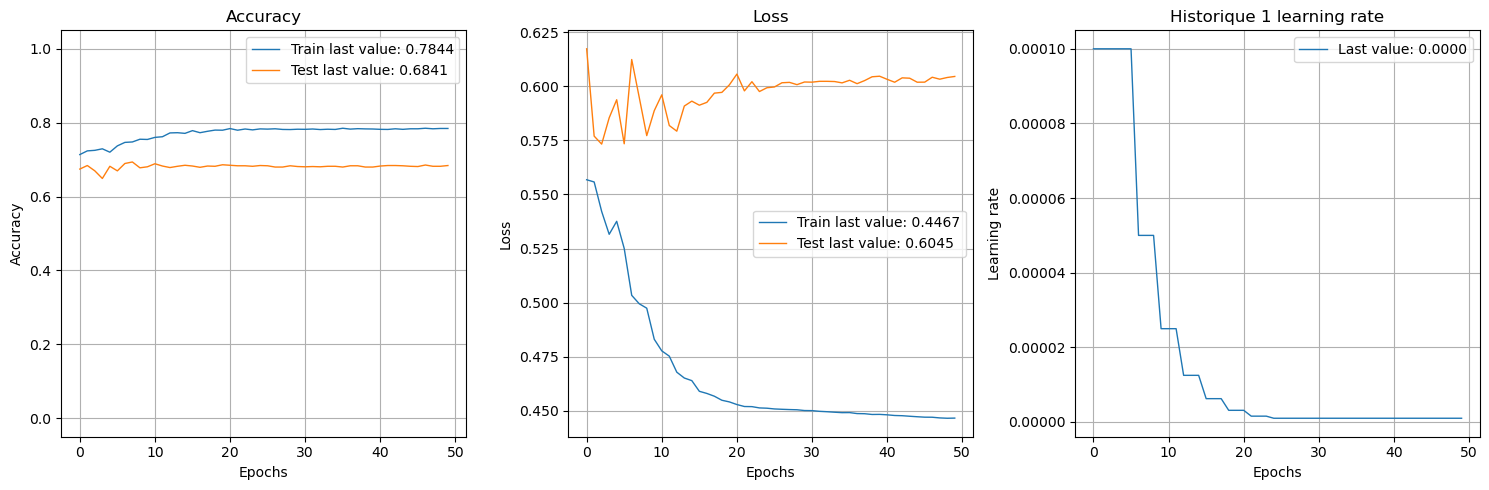

<Figure size 1000x500 with 0 Axes>

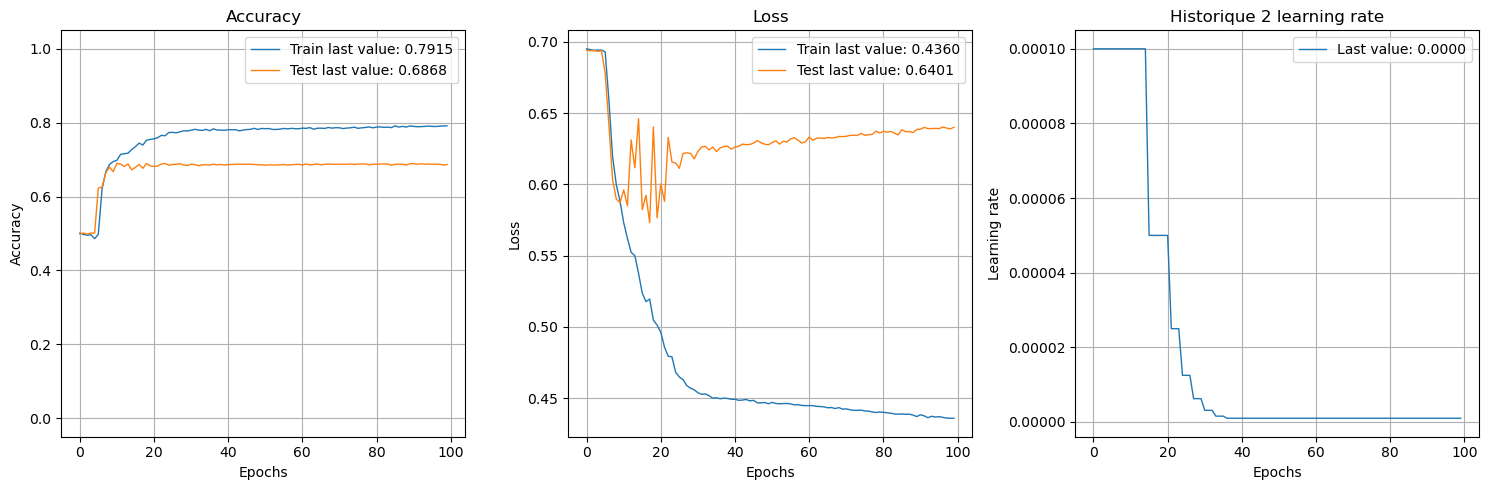

<Figure size 1000x500 with 0 Axes>

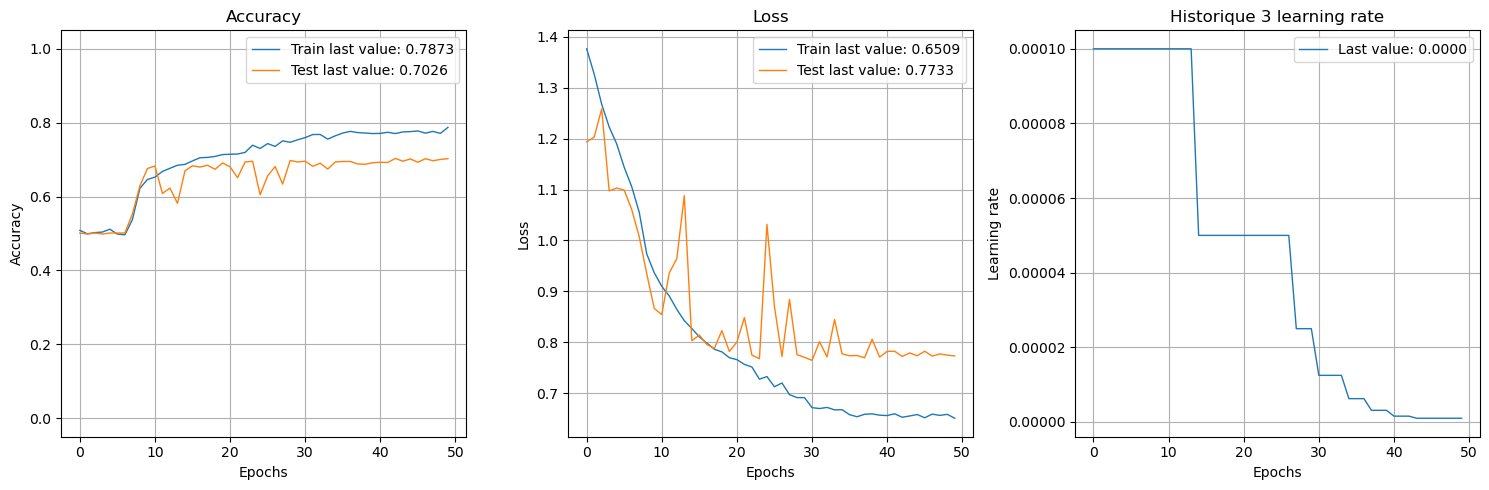

<Figure size 1000x500 with 0 Axes>

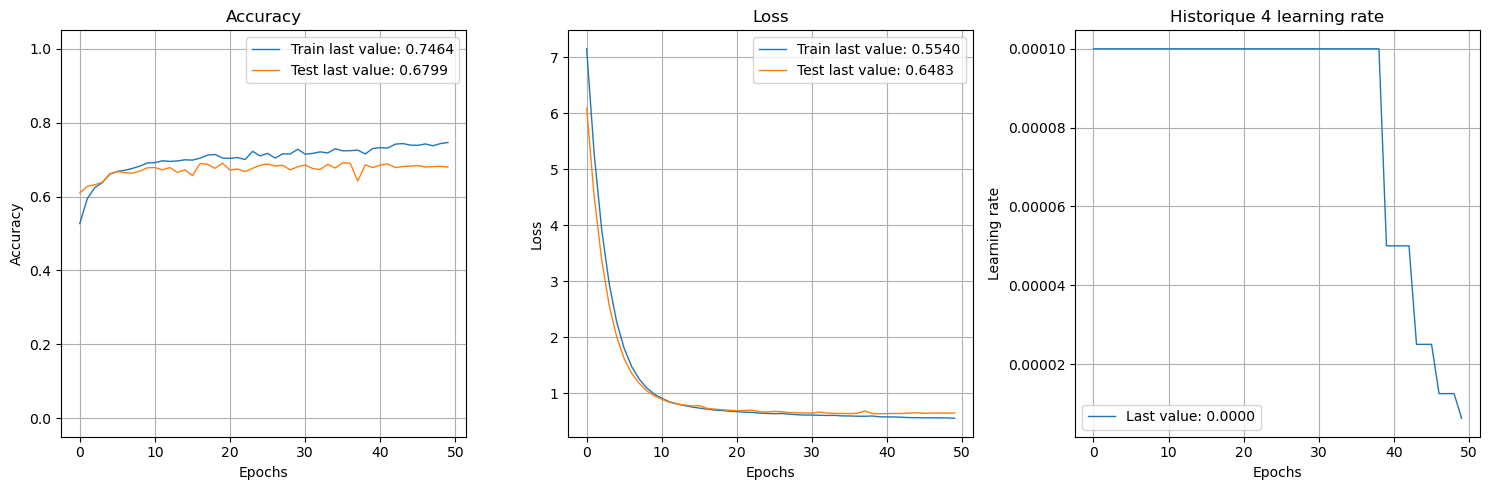

<Figure size 1000x500 with 0 Axes>

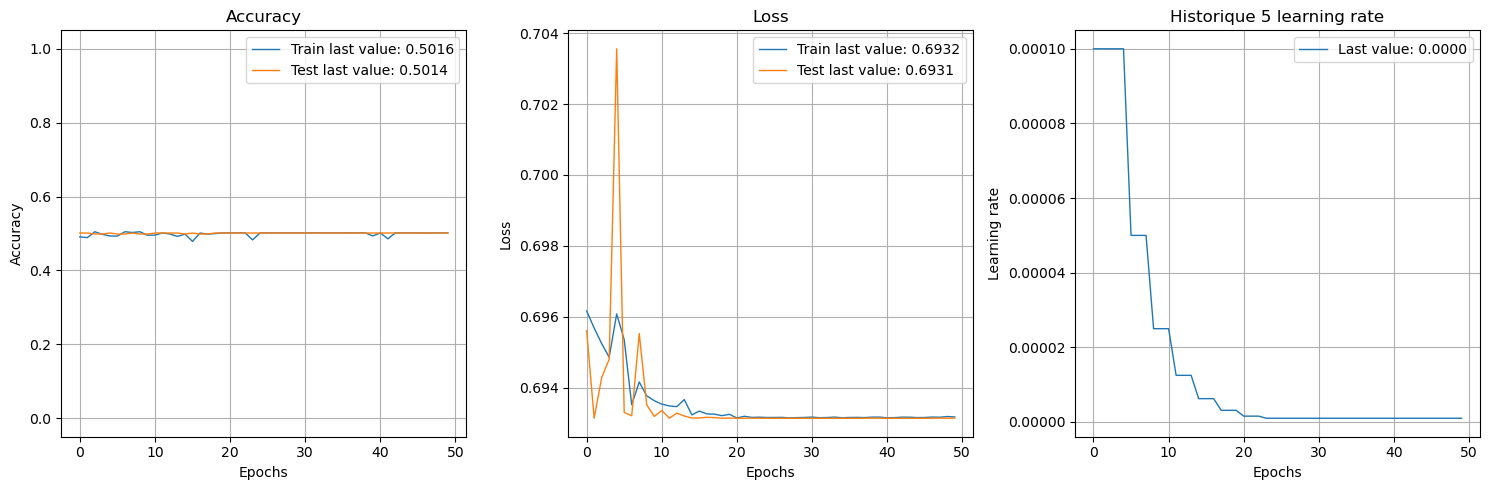

In [164]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

# Supposons que tu as plusieurs historiques
histories = [history_1, history_2, history_3, history_4, history_5]  

# Afficher chaque historique dans un nouveau graphe
for i, history in enumerate(histories):
    plt.figure(figsize=(10, 5))  # Créer une nouvelle figure pour chaque historique
    plot_history(history.history)  # Afficher l'historique
    plt.title(f'Historique {i+1} learning rate')  # Ajouter un titre spécifique
    plt.tight_layout()  # Ajuster les espacements
    plt.show()

## Optimisation automatique du modèle d'embedding

Utilisation de <u><b>Keras tuner</b></u> pour optimiser le modèle en faisant varier:<br>
- le nombre d'unités LSTM
- le taux de dropout
- la régularisation L2
- le taux d'apprentissage <br>
Le modèle utilise une couche LSTM bi-directionnelle à laquelle on a ajouté des couches denses (régulées et avec dropout) qui réduisent progressivement les dimensions vers la couche de sortie.

In [29]:
def build_model(hp):
    model = Sequential()
    
    # 1. Couche d'embedding avec la matrice Word2Vec pré-entraînée
    model.add(Embedding(
        input_dim=embedding_matrix_w2v.shape[0],     
        output_dim=embedding_matrix_w2v.shape[1],         
        weights=[embedding_matrix_w2v],          
        trainable=False              
    ))

    # 2. Couche LSTM bidirectionnelle avec des hyperparamètres tunables
    lstm_units = hp.Int('units', min_value=128, max_value=512, step=64)
    model.add(Bidirectional(LSTM(
        units=lstm_units,
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-6, max_value=1e-3, sampling='log')),  # Intervalle ajusté
        recurrent_regularizer=l2(hp.Float('l2_lambda', min_value=1e-6, max_value=1e-3, sampling='log')),
        dropout=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1),  # Dropout ajusté
        recurrent_dropout=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1),
        return_sequences=False
    )))

    # 3. Première couche Dense avec régularisation L2 et activation ReLU
    dense_units_1 = hp.Int('dense_units_1', min_value=lstm_units//4, max_value=lstm_units//2, step=32)
    model.add(Dense(
        units=dense_units_1,
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-6, max_value=1e-3, sampling='log'))
    ))
    model.add(Dropout(hp.Float('dense_dropout_1', min_value=0.1, max_value=0.3, step=0.1)))

    # 4. Deuxième couche Dense avec régularisation L2 et activation ReLU
    dense_units_2 = hp.Int('dense_units_2', min_value=dense_units_1//2, max_value=dense_units_1, step=16)
    model.add(Dense(
        units=dense_units_2,
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-6, max_value=1e-3, sampling='log'))
    ))
    model.add(Dropout(hp.Float('dense_dropout_2', min_value=0.1, max_value=0.3, step=0.1)))

    # 5. Couche de sortie Dense avec régularisation L2
    model.add(Dense(
        units=1,                      
        activation='sigmoid',          
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-6, max_value=1e-3, sampling='log'))
    ))

    # Optimiseur Adam avec un learning rate tunable
    optimizer = Adam(hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log'))

    # Compilation du modèle
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [30]:
# pip install keras-tuner --upgrade
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [31]:
import os
import shutil
# Supprimer le répertoire s'il existe déjà (pour refaire une mise au point de paramètres à chaque run)
if os.path.exists('my_dir'):
    shutil.rmtree('my_dir')

# Instanciation du tuner après suppression
tuner_W2v = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='my_dir',  # Répertoire standard mais il sera recréé
    project_name='lstm_bidirectional_tuning_W2v'
)

In [ ]:
# Callbacks avec `restore_best_weights`
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Recherche des meilleurs hyperparamètres
tuner_W2v.search(train_padded, y_train, epochs=50, validation_data=(val_padded, y_val), callbacks=[stop_early])

Trial 205 Complete [00h 06m 13s]
val_loss: 0.5639243125915527

Best val_loss So Far: 0.5617563724517822
Total elapsed time: 14h 46m 00s

Search: Running Trial #206

Value             |Best Value So Far |Hyperparameter
512               |384               |units
1.5509e-06        |1.1095e-06        |l2_lambda
0.2               |0.3               |dropout_rate
64                |64                |dense_units_1
0.1               |0.1               |dense_dropout_1
32                |16                |dense_units_2
0.2               |0.1               |dense_dropout_2
0.0003026         |0.0050592         |learning_rate
34                |12                |tuner/epochs
12                |4                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
2                 |1                 |tuner/round
0190              |0168              |tuner/trial_id

Epoch 13/34
107/107 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7271 - loss: 0.5360 - val_accuracy: 0.6966

In [33]:
# Paramètres d'entrainement pour le ré-entrainement
n_epochs = 100
batch_size = 32
# Définir les hyperparamètres de l'entraînement
initial_learning_rate = 0.0001  # Apprentissage initial

In [34]:
# Récupération des meilleurs hyperparamètres
best_hps_W2v = tuner_W2v.get_best_hyperparameters(num_trials=1)[0]

# Entraîner le meilleur modèle avec ces hyperparamètres (utilisation de la fonction des modèles tests)
best_model_W2v = tuner_W2v.hypermodel.build(best_hps_W2v)

# Appel de la fonction d'entraînement avec MLflow
history_W2v_tuned = train_model_with_mlflow(
    model=best_model_W2v,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="best_model_W2v"
)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5239 - loss: 0.6915
Epoch 1: val_loss improved from inf to 0.65960, saving model to ./history/best_model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.5242 - loss: 0.6915 - val_accuracy: 0.6129 - val_loss: 0.6596 - learning_rate: 1.0000e-04
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6113 - loss: 0.6592
Epoch 2: val_loss improved from 0.65960 to 0.62416, saving model to ./history/best_model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6114 - loss: 0.6592 - val_accuracy: 0.6561 - val_loss: 0.6242 - learning_rate: 1.0000e-04
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6390 - loss: 0.6308
Epoch 3: val_loss improved from 0.62416 to 0.61621, saving model to ./history/best_model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6390 - loss: 0.6308 - val_accuracy: 0.6534 - val_loss: 0.6162 - learning_rate: 1.0000e-04
Epoch 4/100
107/107 ━━━

2024/11/13 08:15:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/13 08:15:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


107/107 ━━━━━━━━━━━━━━━━━━━━ 73s 663ms/step


2024/11/13 08:16:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run best_model_W2v at: http://localhost:5000/#/experiments/566106427225564143/runs/6ab2afb9348e43b097de4c7ee034a1fe.
2024/11/13 08:16:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

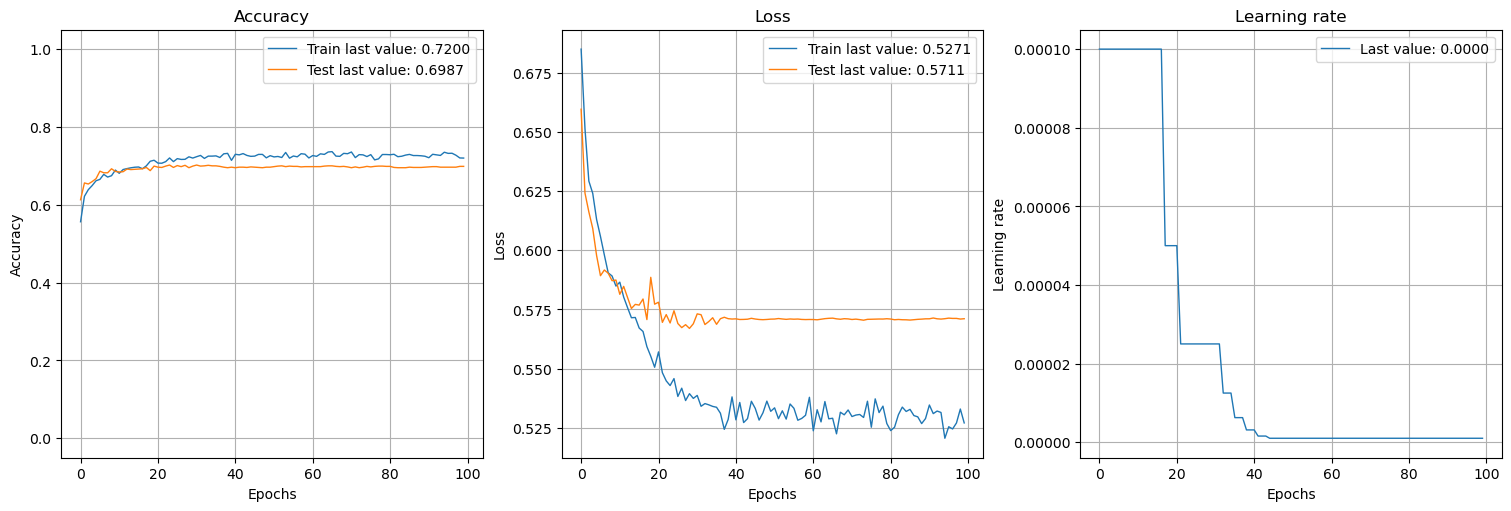

In [35]:
from plot_keras_history import plot_history
# Plot de l'historique de l'entraînement
plot_history(history_W2v_tuned.history)

In [36]:
# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres trouvés :")
print(f" - Units dans LSTM : {best_hps_W2v.get('units')}")
print(f" - Lambda de régularisation L2 : {best_hps_W2v.get('l2_lambda')}")
print(f" - Dropout rate : {best_hps_W2v.get('dropout_rate')}")
print(f" - Learning rate : {best_hps_W2v.get('learning_rate')}")

# Construire le meilleur modèle avec les meilleurs hyperparamètres
# Spécifier l'input_shape correspondant à tes données (par exemple `maxlen`)
input_shape = (maxlen,)  # Nombre max de tokens

# "Build" le modèle explicitement avec la taille d'entrée
best_model_W2v.build(input_shape=(None, *input_shape))  # None correspond à la taille du batch

# Affichage du résumé du modèle
best_model_W2v.summary()

Meilleurs hyperparamètres trouvés :
 - Units dans LSTM : 384
 - Lambda de régularisation L2 : 1.1095279439239067e-06
 - Dropout rate : 0.30000000000000004
 - Learning rate : 0.005059211234433455


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 40, 300)             │       1,832,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 768)                 │       2,104,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,296,481 (31.65 MB)

 Trainable params: 2,154,593 (8.22 MB)

 Non-trainable params: 1,832,700 (6.99 MB)

 Optimizer params: 4,309,188 (16.44 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 33s 653ms/step


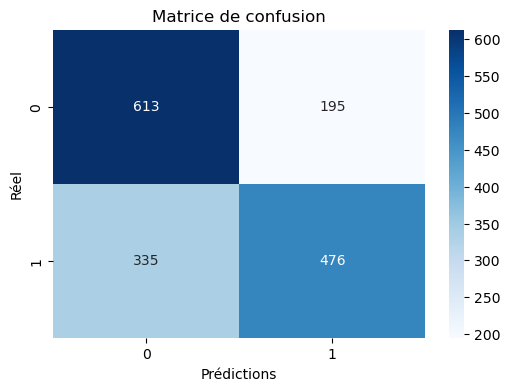

Rapport de classification :
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       808
           1       0.71      0.59      0.64       811

    accuracy                           0.67      1619
   macro avg       0.68      0.67      0.67      1619
weighted avg       0.68      0.67      0.67      1619



In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Faire des prédictions sur le jeu de test
y_pred_probs = best_model_W2v.predict(test_padded)  # Prédictions en probabilités
y_pred = (y_pred_probs > 0.5).astype("int32")   # Conversion en classes (0 ou 1)

# 2. Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# 3. Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réel')
# Sauvegarder l'image de la matrice de confusion
plt.savefig('confusion_matrix.png')
plt.show()

# 4. Afficher le rapport de classification
class_report = classification_report(y_test, y_pred)
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


In [38]:
# Loguer le meilleur modèle et l'historique d'entraînement dans MLflow 
with mlflow.start_run(run_name="best_model_W2v"):
    # Loguer les hyperparamètres
    mlflow.log_params(best_hps_W2v.values)
    
    # Loguer le modèle
    mlflow.keras.log_model(best_model_W2v, "model")
    
    # Loguer l'historique d'entraînement (loss, accuracy, etc.)
    for epoch in range(len(history_W2v_tuned.history['loss'])):
        mlflow.log_metrics({
            'train_loss': history_W2v_tuned.history['loss'][epoch],
            'train_accuracy': history_W2v_tuned.history['accuracy'][epoch],
            'val_loss': history_W2v_tuned.history['val_loss'][epoch],
            'val_accuracy': history_W2v_tuned.history['val_accuracy'][epoch]
        }, step=epoch)
    # Loguer l'image de la matrice de confusion dans MLflow
    mlflow.log_artifact('confusion_matrix.png')
    # Loguer le rapport de classification sous forme de fichier texte
    with open('classification_report.txt', 'w') as f:
        f.write(class_report)    
    # Loguer le rapport de classification dans MLflow
    mlflow.log_artifact('classification_report.txt')

2024/11/13 08:17:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/13 08:17:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/13 08:17:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run best_model_W2v at: http://localhost:5000/#/experiments/566106427225564143/runs/0d4af2b728724e4c9a2d9a930f49a048.
2024/11/13 08:17:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


# Glove

In [89]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Paramètres
EMBEDDING_DIM = 200  # Dimension des embeddings Glove, ex: 50, 100, 200
MAX_NB_WORDS = 10000  # Limite de vocabulaire (nombre maximal de mots)
MAX_SEQUENCE_LENGTH = 40  # Longueur maximale des séquences de texte

# Charger les embeddings Glove
def load_glove_embedding(filepath, embedding_dim):
    embeddings_index = {}
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'{len(embeddings_index)} mots vectorisés chargés depuis Glove.')
    return embeddings_index

# Chargement du fichier Glove twitter 27B (200)
glove_embeddings_index = load_glove_embedding('./Glove/glove.twitter.27B.200d.txt', EMBEDDING_DIM)

1193514 mots vectorisés chargés depuis Glove.


In [117]:
# Tokenizer - créer un index pour chaque mot dans les données
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_df['preprocessed_text'].values)

# Convertir les textes en séquences
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed_text'].values)
val_sequences = tokenizer.texts_to_sequences(val_df['preprocessed_text'].values)
test_sequences = tokenizer.texts_to_sequences(test_df['preprocessed_text'].values)

# Appliquer le padding aux séquences pour les rendre de longueur égale
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
val_padded = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Créer la matrice d'embeddings
word_index = tokenizer.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))  # Nombre total de mots dans le tokenizer

embedding_matrix_glove = np.zeros((nb_words + 1, EMBEDDING_DIM))  # Ajouter +1 pour l'index 0 (padding)

for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[i] = embedding_vector  # Si le mot est trouvé dans Glove

print(f"Matrice d'embeddings créée avec une dimension de {embedding_matrix_glove.shape}")

# Vos labels
y_train = train_df['target'].values
y_val = val_df['target'].values
y_test = test_df['target'].values

Matrice d'embeddings créée avec une dimension de (6141, 200)


In [93]:
import pandas as pd

# Convertir train_padded en DataFrame
train_glove = pd.DataFrame(train_padded)

# Ajouter la colonne 'target' à train_glove
train_glove['target'] = train_df['target'].values

# Convertir test_padded en DataFrame
val_glove = pd.DataFrame(val_padded)

# Ajouter la colonne 'target' à test_glove
val_glove['target'] = val_df['target'].values

# Sauvegarder les DataFrames dans des fichiers CSV
train_glove.to_csv('./data/train_glove.csv', index=False)
val_glove.to_csv('./data/val_glove.csv', index=False)


## Essai d'optimisation du modèle Glove

In [99]:
# Fonction de création du modèle pour Keras Tuner avec embedding Glove
def build_model_glove(hp):
    model = Sequential()
    
    # 1. Couche d'embedding avec la matrice Glove pré-entraînée
    model.add(Embedding(
        input_dim=embedding_matrix_glove.shape[0],     
        output_dim=embedding_matrix_glove.shape[1],         
        weights=[embedding_matrix_glove],          
        trainable=False              
    ))

    # 2. Couche LSTM bidirectionnelle avec des hyperparamètres tunables
    model.add(Bidirectional(LSTM(
        units=hp.Int('units', min_value=64, max_value=256, step=32),
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='log')),  
        recurrent_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='log')),
        dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),  
        recurrent_dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),
        return_sequences=False
    )))

    # 3. Couche de sortie Dense avec régularisation L2
    model.add(Dense(
        units=1,                      
        activation='sigmoid',          
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='log'))
    ))

    # Optimiseur Adam avec un learning rate tunable
    optimizer = Adam(hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log'))

    # Compilation du modèle
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [106]:
import os
import shutil
# Supprimer le répertoire s'il existe déjà (pour refaire une mise au point de paramètres à chaque run)
if os.path.exists('my_dir'):
    shutil.rmtree('my_dir')

# Instanciation du tuner après suppression
# Utilisation de RandomSearch pour garantir 40 epochs par essai et limiter le nombre d'essais
tuner_Glove = kt.RandomSearch(
    build_model_glove,
    objective='val_loss',
    max_trials=100,  # Ajustez le nombre total d'essais si besoin
    executions_per_trial=1,  
    directory='my_dir',
    project_name='tuning_Glove_fixed_epochs'
)

In [ ]:
# Callbacks avec `restore_best_weights`
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Recherche des meilleurs hyperparamètres avec le callback
tuner_Glove.search(
    train_padded, y_train,
    epochs=40,  # Fixé à 40 epochs
    validation_data=(val_padded, y_val),
    callbacks=[stop_early]
)

In [160]:
# Récupération des meilleurs hyperparamètres
best_hps_Glove = tuner_Glove.get_best_hyperparameters(num_trials=1)[0]
best_model_Glove = tuner_Glove.hypermodel.build(best_hps_Glove)

In [161]:
# Paramètres d'entrainement
n_epochs = 100
batch_size = 32
# Définir les hyperparamètres de l'entraînement
initial_learning_rate = 0.0001  # Apprentissage initial

In [162]:
# Entraîner le meilleur modèle avec ces hyperparamètres

from tensorflow.keras.callbacks import ModelCheckpoint

# Définir le callback ModelCheckpoint avec un nom spécifique au modèle
checkpoint_callback = ModelCheckpoint(
    filepath='./models/best_model_Glove.weights.h5',  # fichier où les meilleurs poids sont sauvegardés
    monitor='val_loss',              # surveiller la validation loss
    mode='min',                      # rechercher le minimum de val_loss
    save_best_only=True,             # sauvegarder seulement les meilleurs poids
    save_weights_only=True,          # # sauvegarder seulement les poids pour les récupérer rapidement
    verbose=1                        # afficher un message lorsque les meilleurs poids sont sauvegardés
)

# Entraînement avec le callback ModelCheckpoint et MLflow
history_Glove_tuned = train_model_with_mlflow(
    model=best_model_Glove,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="best_model_Glove",
    callbacks=[checkpoint_callback]  # Ajout du ModelCheckpoint
)

Epoch 1/100
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5283 - loss: 0.7002
Epoch 1: val_loss improved from inf to 0.68801, saving model to ./history/best_model.keras

Epoch 1: val_loss improved from inf to 0.68801, saving model to ./models/best_model_Glove.weights.h5
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5285 - loss: 0.7002 - val_accuracy: 0.6078 - val_loss: 0.6880 - learning_rate: 1.0000e-04
Epoch 2/100
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5988 - loss: 0.6863
Epoch 2: val_loss improved from 0.68801 to 0.67333, saving model to ./history/best_model.keras

Epoch 2: val_loss improved from 0.68801 to 0.67333, saving model to ./models/best_model_Glove.weights.h5
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5988 - loss: 0.6863 - val_accuracy: 0.6257 - val_loss: 0.6733 - learning_rate: 1.0000e-04
Epoch 3/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6190 - loss: 0.6742
Epoch 3: val_loss improved from 0.67333 to 0.65601

2024/10/30 11:56:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/30 11:56:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/30 11:56:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run best_model_Glove at: http://localhost:5000/#/experiments/566106427225564143/runs/3fd98621ee9242b1a9ad3cdb1ba9e85c.
2024/10/30 11:56:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

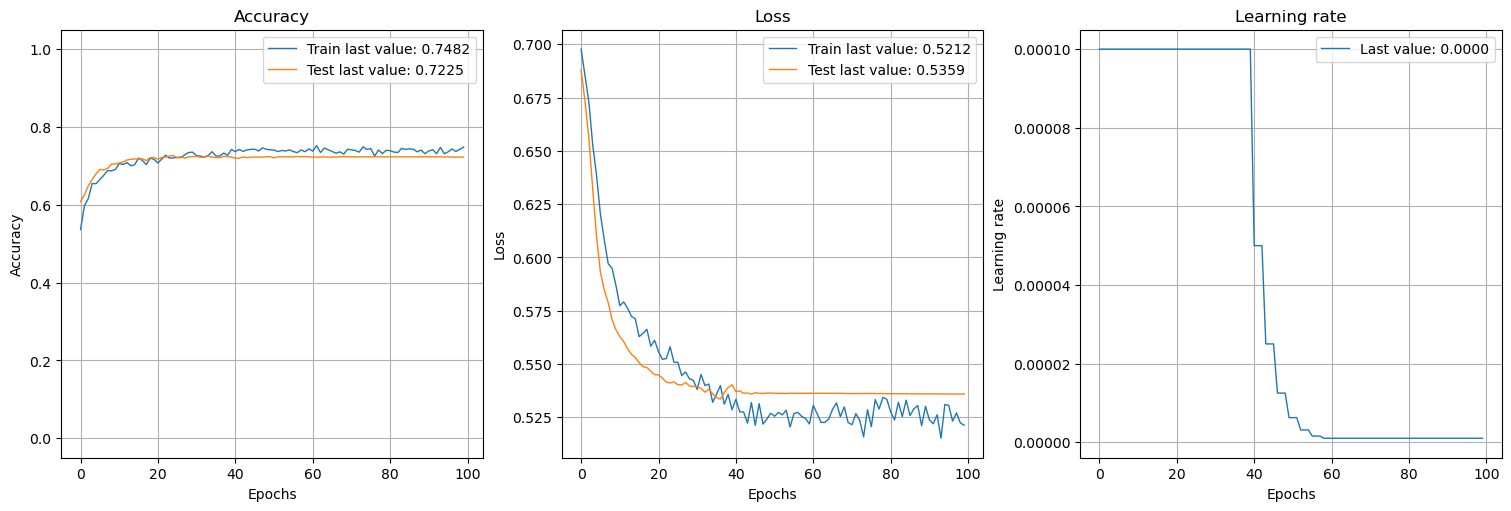

In [163]:
from plot_keras_history import plot_history
# Plot de l'historique de l'entraînement
plot_history(history_Glove_tuned.history)

In [164]:
# Charger les meilleurs poids dans le modèle courant
best_model_Glove.load_weights('./models/best_model_Glove.weights.h5')

In [165]:
# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres trouvés :")
print(f" - Units dans LSTM : {best_hps_Glove.get('units')}")
print(f" - Lambda de régularisation L2 : {best_hps_Glove.get('l2_lambda')}")
print(f" - Dropout rate : {best_hps_Glove.get('dropout_rate')}")
print(f" - Learning rate : {best_hps_Glove.get('learning_rate')}")

# Construire le meilleur modèle avec les meilleurs hyperparamètres
# Spécifier l'input_shape correspondant à tes données (par exemple `maxlen`)
input_shape = (MAX_SEQUENCE_LENGTH,)  # Nombre max de tokens

# "Build" le modèle explicitement avec la taille d'entrée
best_model_Glove.build(input_shape=(None, *input_shape))  # None correspond à la taille du batch

# Affichage du résumé du modèle
best_model_Glove.summary()

Meilleurs hyperparamètres trouvés :
 - Units dans LSTM : 64
 - Lambda de régularisation L2 : 1.6550986881455814e-05
 - Dropout rate : 0.4
 - Learning rate : 0.00012178790424045114


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 40, 200)             │       1,228,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 128)                 │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,635,629 (6.24 MB)

 Trainable params: 135,809 (530.50 KB)

 Non-trainable params: 1,228,200 (4.69 MB)

 Optimizer params: 271,620 (1.04 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


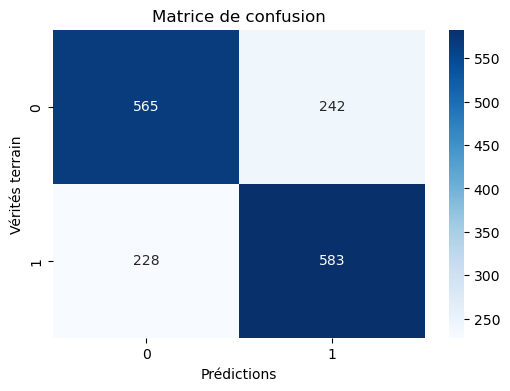

Rapport de classification :
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       807
           1       0.71      0.72      0.71       811

    accuracy                           0.71      1618
   macro avg       0.71      0.71      0.71      1618
weighted avg       0.71      0.71      0.71      1618



In [180]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Faire des prédictions sur le jeu de test
y_pred_probs = best_model_Glove.predict(test_padded)  # Prédictions en probabilités
y_pred = (y_pred_probs > 0.5).astype("int32")   # Conversion en classes (0 ou 1)

# 2. Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# 3. Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.savefig('confusion_matrix.png')
plt.show()

# 4. Afficher le rapport de classification
class_report = classification_report(y_test, y_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


### Log du modèle Glove optimisé dans MLFlow

In [191]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Rechercher l'ID du run nommé "best_model_Glove" dans l'expérience actuelle
# experiment_id = mlflow.get_experiment_by_name("modèle_avancé").experiment_id
runs = mlflow.search_runs(experiment_names=["modele_avancé"], filter_string="tags.mlflow.runName = 'best_model_Glove'")

# Si le run est trouvé, on récupère son ID, sinon on affiche un message d'erreur
if not runs.empty:
    existing_run_id = runs.iloc[0]["run_id"]

    # Ouvrir le run MLflow existant pour y ajouter les logs
    with mlflow.start_run(run_id=existing_run_id):
        
        # Visualisation et enregistrement du rapport de classification
        plt.figure(figsize=(10, 6))
        sns.heatmap(pd.DataFrame(conf_matrix), annot=True, fmt="d", cmap="Blues")
        plt.title("Matrice de Confusion")
        plt.xlabel("Prédictions")
        plt.ylabel("Réel")
        plt.savefig('./history/confusion_matrix.png')
        mlflow.log_artifact('./history/confusion_matrix.png')
        plt.close()

        # Sauvegarder le rapport de classification en CSV et en texte
        class_report_df.to_csv('./history/classification_report.csv')
        mlflow.log_artifact('./history/classification_report.csv')
        mlflow.log_text(class_report_df.to_string(), "classification_report.txt")

else:
    print("Le run 'best_model_Glove' n'a pas été trouvé dans l'expérience spécifiée.")


2024/10/30 16:01:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run best_model_Glove at: http://localhost:5000/#/experiments/566106427225564143/runs/3fd98621ee9242b1a9ad3cdb1ba9e85c.
2024/10/30 16:01:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


# Modèle Bert

<font color="#FF0000">
    NETTOYAGE MEMOIRE ET CACHE DE CALCUL
______________________________________________________________________________________

In [108]:
import gc
# Libérer les objets non référencés
gc.collect()
# Activer le garbage collector de TensorFlow pour GPU
from tensorflow.python.framework import ops
ops.reset_default_graph()
# Libérer la mémoire GPU utilisée par TensorFlow
import tensorflow as tf
tf.keras.backend.clear_session()

<font color="#FF0000">______________________________________________________________________________________

## Ré-entrainement de BertForSequenceClassification.from_pretrained associé à un classifieur binaire (HuggingFace)

In [154]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd


In [5]:
# Colonnes utilisées par BERT
# train_df = train_df[['text', 'target']]
# test_df = test_df[['text', 'target']]
# val_df = val_df[['text', 'target']]
train_labels= train_df['target']
val_labels= val_df['target']
test_labels= test_df['target']

In [156]:
# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokeniser les textes
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(list(val_df['text']), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True, max_length=64)

In [157]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Définir la fonction compute_metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [158]:
# Création d'un dataset PyTorch
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels.tolist())
val_dataset = TweetDataset(val_encodings, val_labels.tolist())
test_dataset = TweetDataset(test_encodings, test_labels.tolist())

In [159]:
training_args = TrainingArguments(
    output_dir='./results',          # où stocker les résultats
    num_train_epochs=5,              # nombre d'époques
    per_device_train_batch_size=8,   # taille du batch pour l'entraînement
    per_device_eval_batch_size=8,    # taille du batch pour l'évaluation
    warmup_steps=500,                 # nombre d'étapes de warmup pour le scheduler
    weight_decay=0.01,                # taux de décroissance du poids
    logging_dir='./logs',            # répertoire de logs
    logging_steps=10,
)


In [160]:
# Charger le modèle BERT pour la classification de séquence
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [162]:
# Initialiser le formateur
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
# Activer le suivi de MLflow pour le run principal
mlflow.start_run(run_name="Bert from pretrained")

# Création d'un run imbriqué pour l'entraînement
with mlflow.start_run(run_name="training", nested=True):
    # Démarre l'entraînement du modèle
    trainer.train()

Step,Training Loss
10,0.693100
20,0.668500
30,0.741200
40,0.726100
50,0.685200
60,0.701100
70,0.698100
80,0.654100
90,0.626400
100,0.641500


🏃 View run training at: http://localhost:5000/#/experiments/566106427225564143/runs/afa7f0342b9d4155954b220733d8462a
🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143


## Log de l'évaluation durant l'entrainement

In [163]:
# Évaluation
# Sous-run pour l'évaluation
with mlflow.start_run(run_name="evaluation", nested=True):
    # Évaluer le modèle sur les données de validation
    eval_results = trainer.evaluate(eval_dataset=val_dataset)

    # Logger les métriques d'évaluation
    for metric, value in eval_results.items():
        mlflow.log_metric(metric, value)

🏃 View run evaluation at: http://localhost:5000/#/experiments/566106427225564143/runs/cfbe6ee3f45341e0b693054e823b93df
🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143


## Allègement du modèle

In [152]:
import torch
import torch.nn.utils.prune as prune
from torch.quantization import quantize_dynamic

# 1. Déplacer le modèle vers le CPU
trained_model = trainer.model.to('cpu')

# 2. Quantization dynamique
# La quantization dynamique est appliquée sur les poids des couches de type Linear
quantized_model = quantize_dynamic(
    trained_model, 
    {torch.nn.Linear},  # Applique la quantization uniquement sur les couches Linear
    dtype=torch.qint8   # Type de quantization (par exemple, qint8 pour une quantization 8-bit)
)

# 3. Pruning des poids du modèle (par exemple, pruning des couches Linear)
# Pruning de 20% des poids dans les couches Linear
for name, module in quantized_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name="weight", amount=0.2)  # Prune 20% des poids

# Afficher les résultats pour vérifier le pruning
for name, module in quantized_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"Pruned weights in {name}: {module.weight.shape}")

In [164]:
# Sauvegarder le modèle résultant du Trainer dans le run principal
mlflow.pytorch.log_model(quantized_model, "model")

2024/11/21 10:34:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/21 10:34:46 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.19.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.19.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/21 10:34:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Predict sur le jeu de test (en testant le rechargement du modèle)

In [169]:
import torch
import mlflow
import mlflow.pytorch

# Vérifier si CUDA est disponible et définir le support de calcul, mais forcer l'utilisation du CPU
device = torch.device("cpu")  # Force l'utilisation du CPU

# Obtenir tous les runs
runs = mlflow.search_runs(filter_string="run_name = 'Bert from pretrained'")

# Récupérer l'ID du premier run correspondant (ou gérer les cas où il n'y en a pas)
if not runs.empty:
    run_id = runs.iloc[0].run_id
    model_path = "model"  # Chemin de l'artefact

    # Charger le modèle depuis le run spécifié
    reloaded_model = mlflow.pytorch.load_model(f"runs:/{run_id}/{model_path}")

    # Déplacer le modèle explicitement sur le CPU
    reloaded_model.to(device)

    # Vérifier que le modèle est chargé
    print("Modèle chargé avec succès.")
else:
    print("Aucun run trouvé avec le nom 'Bert from pretrained'.")


Modèle chargé avec succès.


In [170]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [171]:
def predict_all(texts, model):
    predictions = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
        
        # Déplacer les inputs vers le même appareil que le modèle
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        with torch.no_grad():  # Pas besoin de calculer les gradients pour la prédiction
            outputs = model(**inputs)
        predictions.append(torch.argmax(outputs.logits, dim=1).item())
    return predictions

In [172]:
test_predictions= predict_all(test_df["text"], reloaded_model)

              precision    recall  f1-score   support

    Negative       0.81      0.81      0.81       808
    Positive       0.81      0.81      0.81       811

    accuracy                           0.81      1619
   macro avg       0.81      0.81      0.81      1619
weighted avg       0.81      0.81      0.81      1619



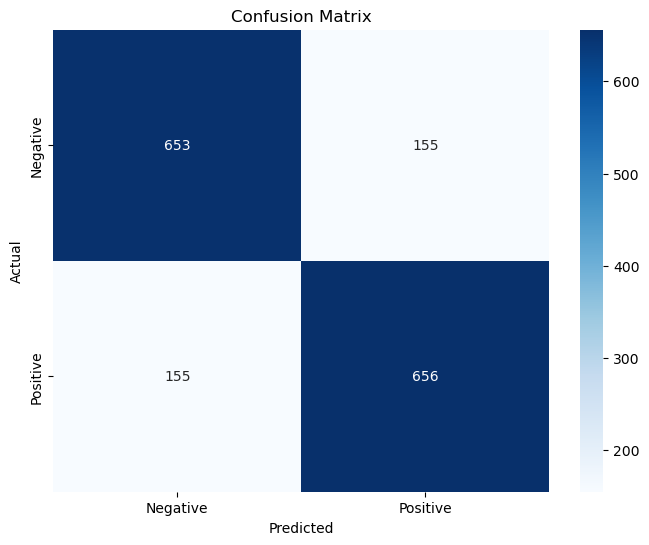

In [173]:
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

# Calculer le rapport de classification
classification_rep = classification_report(test_labels, test_predictions, target_names=["Negative", "Positive"])
print(classification_rep)

# Logger le rapport de classification dans MLflow
mlflow.log_text(classification_rep, "classification_report.txt")

# Calculer la matrice de confusion
cm = confusion_matrix(test_labels, test_predictions)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")  # Sauvegarder la matrice de confusion en tant qu'image
plt.show()

# Logger la matrice de confusion dans MLflow
mlflow.log_artifact("confusion_matrix.png")

# Supprimer les fichiers une fois loggés
os.remove("confusion_matrix.png")
# os.remove("classification_report.txt")


### Log du modèle complet wrappé avec signature (Bert_with_preprocessing)
Pour simplifier le script de l'API nous intégrons la préparation des données au modèle dans un modèle wrapper.

In [174]:
import mlflow.pyfunc
import torch
from transformers import BertTokenizer
import shutil
# shutil.rmtree("bert_with_preprocessing")


class BertWithPreprocessing(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        # Utilisation du modèle existant sans le recharger
        self.model = reloaded_model  # le modèle chargé lors du test (allégé)
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.device = torch.device("cpu")  # Initialisation sur CPU par défaut

    def to(self, device):
        # Déplace le modèle sous-jacent vers le bon appareil
        self.device = device
        self.model.to(device)
    
    def predict(self, context, model_input):
        # Gérer différents types de structures pour `model_input`
        if isinstance(model_input, pd.DataFrame):
            text = model_input["text"].iloc[0]  # Prendre la première ligne du DataFrame (une seule phrase)
        elif isinstance(model_input, list):
            text = model_input[0]  # Utiliser directement la première phrase de la liste
        elif isinstance(model_input, str):
            text = model_input  # Si c'est déjà une chaîne, l'utiliser directement
        else:
            raise ValueError("Le format de `model_input` n'est pas supporté.")
        
        # Prétraitement de la phrase
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=64
        )
        
        # Déplacer les inputs sur le bon appareil
        inputs = {key: tensor.to(self.device) for key, tensor in inputs.items()}
        
        # Prédiction
        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Assurez-vous que les prédictions soient renvoyées sur le CPU pour compatibilité avec numpy
        
        return predictions


# Démarrer le run et enregistrer le modèle dans l'expérience et le run en cours
with mlflow.start_run(run_name="Bert_with_preprocessing", nested=True) as run:
    bert_model = BertWithPreprocessing()
    mlflow.pyfunc.log_model(artifact_path="bert_with_preprocessing", python_model=bert_model)

2024/11/21 10:46:37 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.19.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.19.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/21 10:46:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Bert_with_preprocessing at: http://localhost:5000/#/experiments/566106427225564143/runs/6c81f9e94e4f482baad29a41ec53aebf
🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143


In [175]:
# Déplacer le modèle sur le CPU car l'exécution sur GPU n'est pas requise
bert_model.load_context(context=None)  # Charger le modèle dans self.model
device = torch.device("cpu")  #"cuda" if torch.cuda.is_available() else 
bert_model.to(device)

In [176]:
print("Le modèle est sur :", next(bert_model.model.parameters()).device)

Le modèle est sur : cpu


In [177]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec
import mlflow

# Exemple d'entrée pour le modèle
# Utilisez une seule phrase pour l'exemple
INPUT_EXAMPLE = ["I love machine learning!"]

# Signature d'entrée
input_schema = Schema([ColSpec("string", "text")])  # Changez 'texts' en 'text'
output_schema = Schema([ColSpec("integer")])  # Le modèle retourne une prédiction entière
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

# Récupérez l'ID du run actuel
current_run_id = mlflow.active_run().info.run_id

# Compléter les artifacts loggés sous ce run existant
with mlflow.start_run(run_id=current_run_id, nested=True):
    mlflow.pyfunc.log_model(
        artifact_path="complete_bert_with_preprocessing",
        python_model=bert_model,  # Le modèle doit être votre objet 'BertWithPreprocessing'
        signature=signature,
        input_example=INPUT_EXAMPLE
    )


2024/11/21 10:48:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.19.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.19.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


🏃 View run Bert from pretrained at: http://localhost:5000/#/experiments/566106427225564143/runs/e2b22363be6a427a8bdad0ad7cbc8584
🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143


### Validation du modèle loggé (code fourni par MLFlow)

In [178]:
from mlflow.models import validate_serving_input

model_uri = 'runs:/e2b22363be6a427a8bdad0ad7cbc8584/complete_bert_with_preprocessing'

# The model is logged with an input example. MLflow converts
# it into the serving payload format for the deployed model endpoint,
# and saves it to 'serving_input_payload.json'
serving_payload = """{
  "inputs": [
    "I love machine learning!"
  ]
}"""

# Validate the serving payload works on the model
validate_serving_input(model_uri, serving_payload)

array([0], dtype=int64)

In [179]:
# Test du modèle avec pre-processing
import pandas as pd
import mlflow

# Charger le modèle avec schéma et signature
logged_model = model_uri
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Échantillonner 1 ligne aléatoire de la colonne "text" de test_df
data = test_df[['text']].sample(1).reset_index(drop=True)

# Effectuer la prédiction
predictions = loaded_model.predict(data)

# Afficher la phrase et le sentiment en fonction de la prédiction
for i, pred in enumerate(predictions):
    print(f"Phrase: {data.iloc[i]['text']}")
    if pred == 1:
        print("Sentiment négatif")
    else:
        print("Sentiment postif")


Phrase: I'm so sad about the Air France Jet crash. It's crazy, the plane just disappeared. Poor travelers...  http://is.gd/LKkT
Sentiment négatif


In [180]:
# Test du predict avec une phrase nouvelle

# Exemple d'entrée sous forme de chaîne
sentence = "My baggage was damaged and the airline took no responsibility for it."

# Ou sous forme de DataFrame (1 phrase)
import pandas as pd
data = pd.DataFrame({"text": [sentence]})

# Effectuer la prédiction
predictions = loaded_model.predict(data)

# Affichage du sentiment basé sur la prédiction
for pred in predictions:
    if pred == 0:
        print("Sentiment : positif")
    else:
        print("Sentiment : négatif")

Sentiment : négatif


### Enregistrement du modèle loggé

In [181]:
# Enregistrer le modèle dans le Model Registry local
import mlflow

# Nom du modèle dans le Model Registry
model_name = "BertModelSequenceClassificationFromPretrained"

# Enregistrement du modèle dans le registre sous le nom spécifié
model_version = mlflow.register_model(model_uri=model_uri, name=model_name)

# Ajout de l'alias "champion" à la dernière version du modèle
client = mlflow.tracking.MlflowClient()
client.set_registered_model_alias(name=model_name, alias="champion", version=model_version.version)

print(f"Modèle enregistré avec succès sous le nom '{model_name}' avec l'alias 'champion'.")

Registered model 'BertModelSequenceClassificationFromPretrained' already exists. Creating a new version of this model...
2024/11/21 10:51:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BertModelSequenceClassificationFromPretrained, version 3


Modèle enregistré avec succès sous le nom 'BertModelSequenceClassificationFromPretrained' avec l'alias 'champion'.


Created version '3' of model 'BertModelSequenceClassificationFromPretrained'.


In [182]:
# Terminer le run
mlflow.end_run()

🏃 View run Bert from pretrained at: http://localhost:5000/#/experiments/566106427225564143/runs/e2b22363be6a427a8bdad0ad7cbc8584
🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143


### Sauvegarde du modèle sur Azure Blob

In [183]:
import mlflow
import os
import shutil

# URI du modèle dans le Model Registry
model_name = "BertModelSequenceClassificationFromPretrained"
model_version = "3"
model_uri = f"models:/{model_name}/{model_version}"

# Répertoire local pour enregistrer le modèle
model_dir = "./model_temp"  # Répertoire temporaire

# Supprimer le répertoire s'il existe déjà
if os.path.exists(model_dir):
    shutil.rmtree(model_dir)

# Télécharger le modèle depuis MLflow
mlflow.artifacts.download_artifacts(artifact_uri=model_uri, dst_path=model_dir)

print(f"Modèle téléchargé en local sous {model_dir}")


Modèle téléchargé en local sous ./model_temp


In [184]:
from azure.storage.blob import BlobServiceClient
import os
import shutil

# Chaîne de connexion Azure Storage
storage_connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")
container_name = "oc-p7-modeles"

# Initialiser le client de service Blob
blob_service_client = BlobServiceClient.from_connection_string(storage_connection_string)

# Chemin du répertoire contenant le modèle
local_model_path = model_dir

# Upload des fichiers du modèle
for root, dirs, files in os.walk(local_model_path):
    for file_name in files:
        # Chemin local du fichier
        file_path = os.path.join(root, file_name)

        # Chemin dans le container Azure Blob
        blob_name = os.path.relpath(file_path, local_model_path)
        blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

        # Upload du fichier
        with open(file_path, "rb") as data:
            blob_client.upload_blob(data, overwrite=True)

print(f"Modèle uploadé dans le container Azure Blob '{container_name}'.")

# Suppression du dossier local après l'upload
try:
    # Vérifie si le dossier existe
    if os.path.exists(local_model_path) and os.path.isdir(local_model_path):
        # Suppression récursive du répertoire et de son contenu
        shutil.rmtree(local_model_path)
        print(f"Dossier local '{local_model_path}' supprimé.")
    else:
        print(f"Le dossier local '{local_model_path}' n'existe pas.")
except Exception as e:
    print(f"Erreur lors de la suppression du dossier local : {e}")


Modèle uploadé dans le container Azure Blob 'oc-p7-modeles'.
Dossier local './model_temp' supprimé.


## Classification depuis un embedding Bert

In [6]:
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd

In [7]:
# Charger le tokenizer et le modèle BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Définir l'appareil (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [9]:
import numpy as np
# Production des embeddings
def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        # Tokeniser le texte
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

        # Obtenir les embeddings
        with torch.no_grad():  # Pas besoin de calculer les gradients
            outputs = model(**inputs)
        
        # Les embeddings de la dernière couche cachée
        last_hidden_states = outputs.last_hidden_state
        
        # Prendre la moyenne des embeddings sur la dimension des tokens
        pooled_output = last_hidden_states.mean(dim=1).cpu().numpy()  # Convertion en numpy pour faciliter l'utilisation
        embeddings.append(pooled_output)

    return np.vstack(embeddings)  # Retourner un tableau numpy 2D

# Produire des embeddings pour les tweets
bert_embeddings = get_bert_embeddings(tweets_df['text'])

In [10]:
# Transformer les embeddings en DataFrame
bert_embeddings_df = pd.DataFrame(bert_embeddings)
bert_embeddings_df['target'] = tweets_df['target'].values

# Sauvegarder le DataFrame en fichier CSV dans ./data => AutoML
bert_embeddings_df.to_csv('./data/bert_embeddings.csv', index=False)

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Pour ce test rapide on prend le dataset complet puis train/test split
target = tweets_df['target'].values
X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, target, test_size=0.2, random_state=42)

# Définir les classifieurs
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
}

# Tester chaque classifieur
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))


Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       639
           1       0.78      0.75      0.77       656

    accuracy                           0.77      1295
   macro avg       0.77      0.77      0.77      1295
weighted avg       0.77      0.77      0.77      1295

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70       639
           1       0.71      0.71      0.71       656

    accuracy                           0.71      1295
   macro avg       0.71      0.71      0.71      1295
weighted avg       0.71      0.71      0.71      1295

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.75      0.80      0.78       639
           1       0.79      0.75      0.77       656

    accuracy                           0.77      1295
   mac

C:\Users\cecil\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [18:27:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.73      0.74      0.73       639
           1       0.74      0.73      0.74       656

    accuracy                           0.74      1295
   macro avg       0.74      0.74      0.74      1295
weighted avg       0.74      0.74      0.74      1295

[LightGBM] [Info] Number of positive: 2588, number of negative: 2590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 5178, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499807 -> initscore=-0.000772
[LightGBM] [Info] Start training from score -0.000772
Classification Report for LightGBM:
               precision    recall  f1-score   support

           0       0.73      0.74      0.73       6

De façon immédiate la régression logistique ou SVM produisent une classification avec 77% d'exactitude. AutoML fait légèrement mieux 0.777 avec un modèle d'ensemble stacké <br>
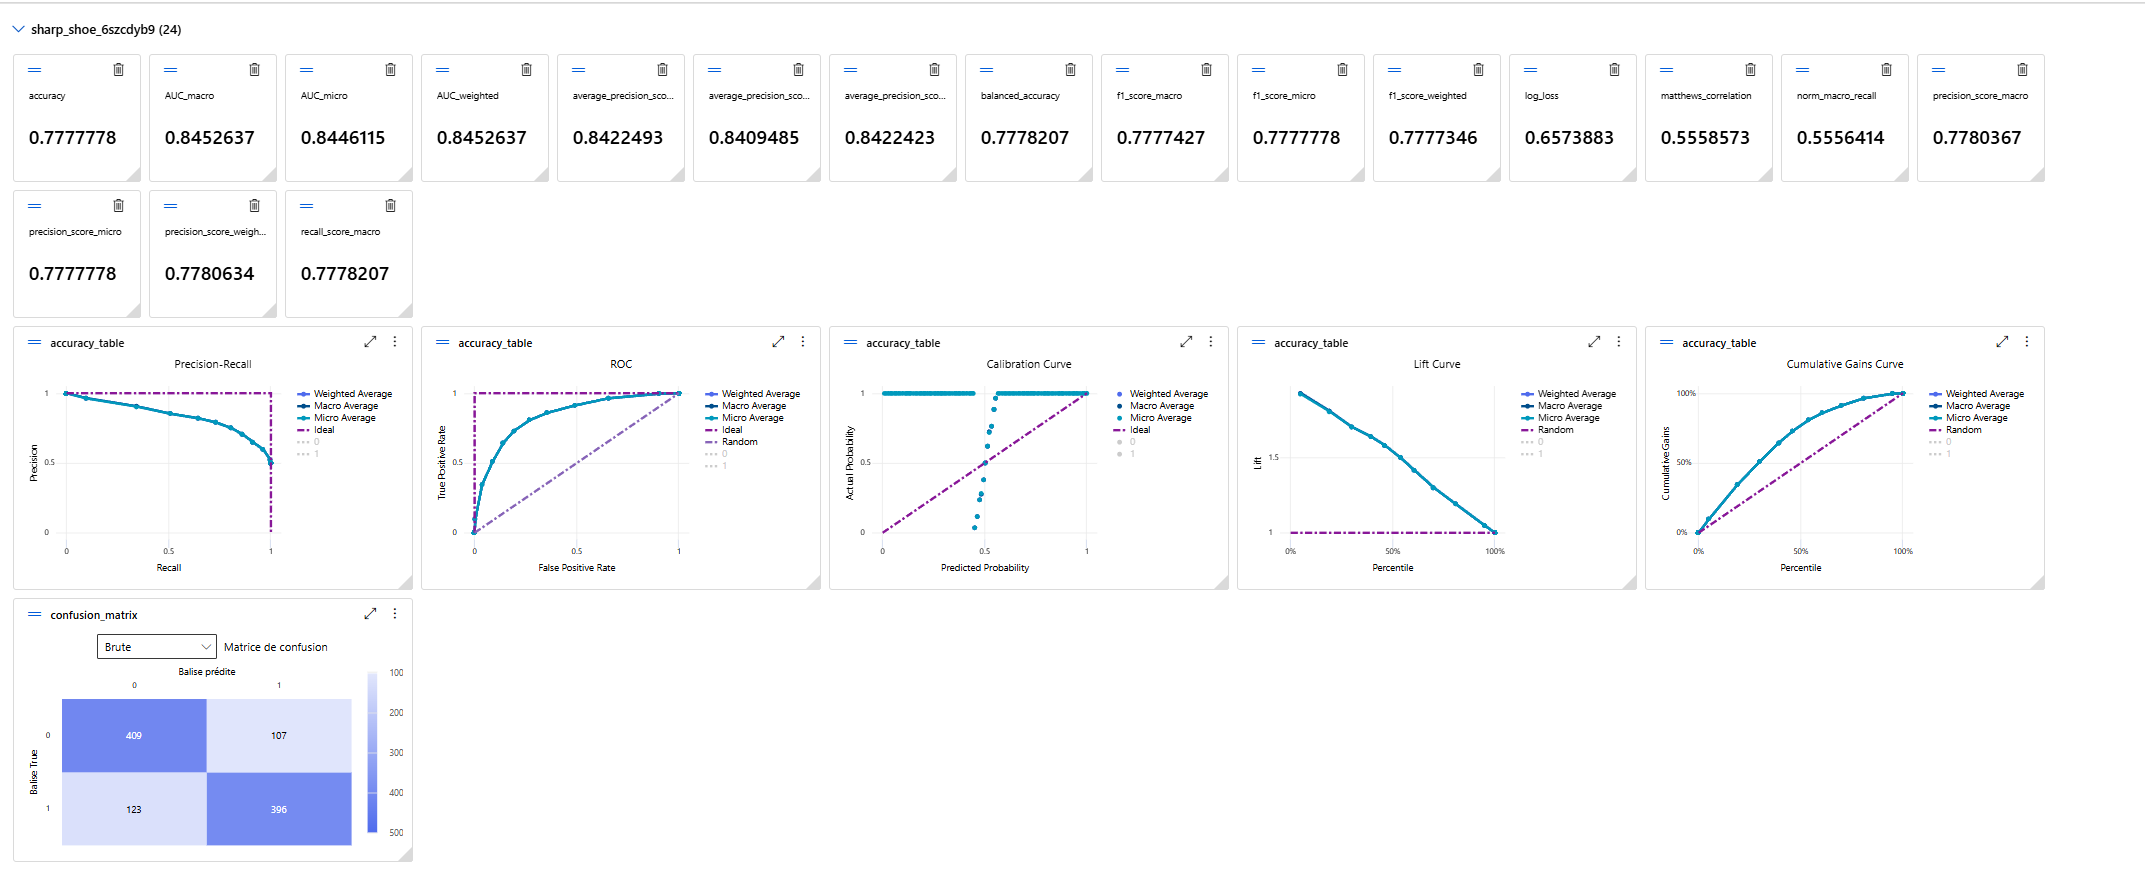

### Optimisation d'une régression logistique
L'intérêt est de comparer les résultats de régression logistique obtenus depuis un embedding par comptage (TfIdF avait donné les meilleurs résultats) par rapport à l'embedding de Bert.

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd 

# Charger les données
X = bert_embeddings_df.drop(columns=["target"])
y = bert_embeddings_df["target"]

def objective(trial):
    # Définir les hyperparamètres à optimiser
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    penalty = 'l2' if solver == 'lbfgs' else trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    # Créer et entraîner le modèle
    model = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=1000)
    # Utiliser la validation croisée pour évaluer les performances
    accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
    
    return accuracy

# Initialiser et exécuter l'optimisation Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Meilleurs paramètres et meilleure performance
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

# Entraîner le modèle final avec les meilleurs paramètres
best_model_lr_Bert_embedding = LogisticRegression(**study.best_params, max_iter=1000)
best_model_lr_Bert_embedding.fit(X, y)


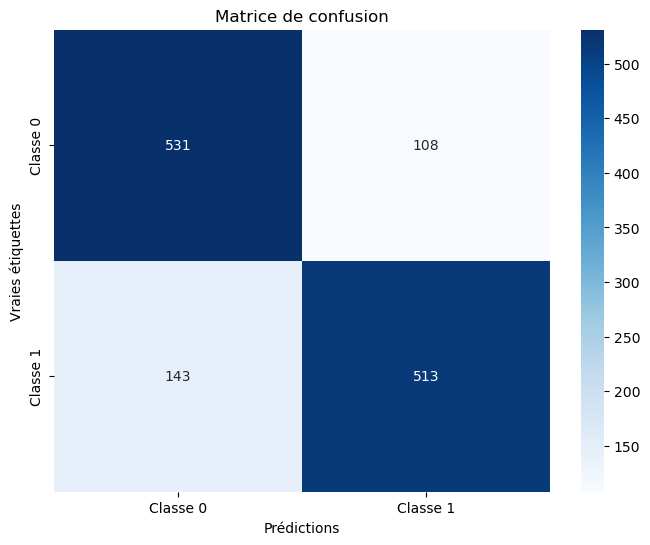

Rapport de classification:
               precision    recall  f1-score   support

    Classe 0       0.79      0.83      0.81       639
    Classe 1       0.83      0.78      0.80       656

    accuracy                           0.81      1295
   macro avg       0.81      0.81      0.81      1295
weighted avg       0.81      0.81      0.81      1295



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Prédictions sur les données de test
y_pred = best_model_lr_Bert_embedding.predict(X_test)

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de confusion")
plt.show()

# Afficher le rapport de classification
report = classification_report(y_test, y_pred, target_names=["Classe 0", "Classe 1"])
print("Rapport de classification:\n", report)


On arrive à gagner 10% d'accuracy par rapport à une régression logistique depuis un embedding par comptage. Il est également intéressant de voir que les performances de ce modèle sont équivalentes à celle du modèle Bert ré-entrainé. Le classifieur est très simple, rapide et efficace ; meilleur que celui mis au point par AutoML.

### Log du modèle Classification with Bert Embedding

In [47]:
mlflow.end_run()

🏃 View run Classification with Bert embedding at: http://localhost:5000/#/experiments/566106427225564143/runs/1b1c696e43ce4514848049c11431be24
🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143


In [48]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Démarrer un nouveau run MLflow
mlflow.start_run(run_name="Classification with Bert embedding")

# Logger les meilleurs paramètres
mlflow.log_params(study.best_params)

# Logger le modèle entraîné
mlflow.sklearn.log_model(best_model_lr_Bert_embedding, "model")

# Prédictions sur le jeu de test
y_pred = best_model_lr_Bert_embedding.predict(X_test)

# Calculer les métriques
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["Classe 0", "Classe 1"], output_dict=True)

# Logger les métriques principales
mlflow.log_metric("accuracy", accuracy)
mlflow.log_metric("precision_classe_0", report["Classe 0"]["precision"])
mlflow.log_metric("recall_classe_0", report["Classe 0"]["recall"])
mlflow.log_metric("f1_classe_0", report["Classe 0"]["f1-score"])
mlflow.log_metric("precision_classe_1", report["Classe 1"]["precision"])
mlflow.log_metric("recall_classe_1", report["Classe 1"]["recall"])
mlflow.log_metric("f1_classe_1", report["Classe 1"]["f1-score"])

# Générer et sauvegarder la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de confusion")
conf_matrix_path = "./confusion_matrix.png"
plt.savefig(conf_matrix_path)
plt.close()

# Logger la matrice de confusion
mlflow.log_artifact(conf_matrix_path)

# Logger le rapport de classification en texte
report_path = "./classification_report.txt"
with open(report_path, "w") as f:
    f.write(classification_report(y_test, y_pred, target_names=["Classe 0", "Classe 1"]))
mlflow.log_artifact(report_path)

# Définir un exemple d'entrée et de sortie pour la signature
input_example = np.array(X_test[0]).reshape(1, -1).astype(np.float32)  # Exemple d'entrée à partir de X_test
output_example = np.array([y_pred[0]]).astype(np.int32)  # Exemple de sortie correspondant à l'exemple d'entrée

# Créer une signature de modèle
signature = mlflow.models.signature.infer_signature(input_example, output_example)

# Logger le modèle avec la signature et l'exemple d'entrée
mlflow.sklearn.log_model(best_model_lr_Bert_embedding, "model", signature=signature, input_example=input_example)

# Nettoyer les fichiers temporaires
os.remove(conf_matrix_path)
os.remove(report_path)

# Le run reste actif ici. Ajoutez vos instructions supplémentaires si nécessaire.

# Fin du run (peut être appelée plus tard)
# mlflow.end_run()


2024/11/21 21:07:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Classification par réseau de neurones depuis l'embedding de Bert
Nous allons mettre en oeuvre le réseau complexe (LSTM bidirectionnel avec régularisation) développé pour WordtoVec et Glove.

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.regularizers import l2

# Instanciation du modèle séquentiel
model_BERT_embedding = Sequential()

# Ajout de la couche d'entrée avec une dimension supplémentaire
model_BERT_embedding.add(Input(shape=(X.shape[1],)))  # X.shape[1] correspond à la taille de l'embedding BERT
model_BERT_embedding.add(Reshape((1, X.shape[1])))    # Reshape pour ajouter la dimension "timesteps" attendue par LSTM

# Ajout d'une couche LSTM bidirectionnelle avec régularisation L2
model_BERT_embedding.add(Bidirectional(LSTM(128)))   #, kernel_regularizer=l2(0.01)

# Ajout d'une couche Dropout pour éviter le sur-ajustement
model_BERT_embedding.add(Dropout(0.8))

# Optionnel : Ajout d'une couche dense pour réduire la complexité du modèle
model_BERT_embedding.add(Dense(64, activation='relu'))
model_BERT_embedding.add(Dropout(0.5))

# Ajout d'une couche de sortie pour la classification binaire
model_BERT_embedding.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model_BERT_embedding.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage de la structure du modèle
model_BERT_embedding.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)                  │ (None, 1, 768)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 256)                 │         918,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 935,041 (3.57 MB)

 Trainable params: 935,041 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Paramètres d'entrainement communs
n_epochs = 50
batch_size = 16
# Définir les hyperparamètres de l'entraînement
initial_learning_rate = 0.0001  # Apprentissage initial

In [94]:
# Appel de la fonction d'entraînement avec MLflow
history_BERT_embedding = train_model_with_mlflow(
    model=model_BERT_embedding,
    train_data=X_train,
    train_labels=y_train,
    validation_data=X_test,
    validation_labels=y_test,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_BERT_embedding_BLSTM128"
)


Epoch 1/50
312/324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5280 - loss: 0.6965
Epoch 1: val_loss improved from inf to 0.63939, saving model to ./history/best_model.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5291 - loss: 0.6960 - val_accuracy: 0.6708 - val_loss: 0.6394 - learning_rate: 1.0000e-04
Epoch 2/50
316/324 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6365 - loss: 0.6427
Epoch 2: val_loss improved from 0.63939 to 0.58110, saving model to ./history/best_model.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6369 - loss: 0.6423 - val_accuracy: 0.7048 - val_loss: 0.5811 - learning_rate: 1.0000e-04
Epoch 3/50
318/324 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6705 - loss: 0.6052
Epoch 3: val_loss improved from 0.58110 to 0.55038, saving model to ./history/best_model.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6706 - loss: 0.6051 - val_accuracy: 0.7272 - val_loss: 0.5504 - learning_rate: 1.0000e-04
Epoch 4/50
311/324 ━━━━━━━

2024/11/02 11:05:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/02 11:06:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024/11/02 11:06:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run training_model_BERT_embedding_BLSTM128 at: http://localhost:5000/#/experiments/566106427225564143/runs/a412c4f83deb4378ba85920e91dc7232.
2024/11/02 11:06:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Le gain d'un réseau de neurones n'est pas prouvé, le temps d'entrainement est beaucoup plus important qu'une régression logistique.

## Fine-tuning Bert (HuggingFace)

In [96]:
# Test de fonctionnement du GPU
import torch

# Vérifie si un GPU est disponible
if torch.cuda.is_available():
    print("Le GPU est activé et sera utilisé.")
else:
    print("Pas de GPU disponible, utilisation du CPU.")


Le GPU est activé et sera utilisé.


In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Charger tes données
tweets_df = pd.read_csv("./data/data_autoML.csv")

# Diviser en ensembles d'entraînement et de test
train_df, test_df = train_test_split(tweets_df, test_size=0.2, random_state=42)

# Créer des datasets à partir des DataFrames avec les étiquettes
train_dataset = Dataset.from_pandas(train_df[['text', 'target']])
test_dataset = Dataset.from_pandas(test_df[['text', 'target']])

# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokeniser les textes
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Renommer la colonne des étiquettes
train_dataset = train_dataset.rename_column("target", "labels")
test_dataset = test_dataset.rename_column("target", "labels")

# Charger le modèle BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Définir les arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Créer un Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Lancer l'entraînement
trainer.train()


Map:   0%|          | 0/5175 [00:00<?, ? examples/s]

Map:   0%|          | 0/1294 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.417580
2,0.441500,0.448523
3,0.441500,0.580464


2024/11/02 11:27:23 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id 94e1767130864eecb93037c25dec0e99: Failed to log run data: Exception: API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


TrainOutput(global_step=972, training_loss=0.3406699616232036, metrics={'train_runtime': 6090.7157, 'train_samples_per_second': 2.549, 'train_steps_per_second': 0.16, 'total_flos': 4084799134464000.0, 'train_loss': 0.3406699616232036, 'epoch': 3.0})

In [102]:
# Sauvegarder le modèle
trainer.save_model("./models/BERT_retrained")


In [103]:
from transformers import BertForSequenceClassification

# Charger le modèle
model_BERT_retrained = BertForSequenceClassification.from_pretrained("./models/BERT_retrained")


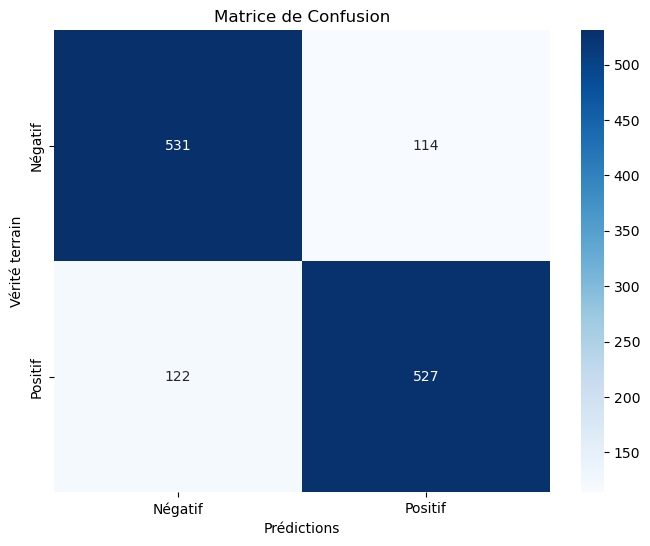

Rapport de Classification:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       645
           1       0.82      0.81      0.82       649

    accuracy                           0.82      1294
   macro avg       0.82      0.82      0.82      1294
weighted avg       0.82      0.82      0.82      1294



In [107]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transférer le modèle sur le GPU si disponible
model_BERT_retrained.to(device)
model_BERT_retrained.eval()

# 1. Charger les données de test et obtenir les étiquettes
labels = test_dataset["labels"]

# Créer une liste pour stocker les prédictions
predictions = []

# 2. Effectuer les prédictions batch par batch pour éviter les dépassements de mémoire
for i in range(0, len(test_dataset), 32):  # Utilise un batch size de 32 pour chaque sous-ensemble
    # Sélectionner un batch de données
    batch = test_dataset.select(range(i, min(i + 32, len(test_dataset))))
    
    # Transférer les tenseurs d'entrée sur le même appareil que le modèle
    input_ids = torch.tensor(batch["input_ids"]).to(device)
    attention_mask = torch.tensor(batch["attention_mask"]).to(device)

    with torch.no_grad():
        outputs = model_BERT_retrained(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()  # Transférer les prédictions sur CPU pour faciliter l'analyse
        predictions.extend(batch_predictions)

# Convertir les listes en numpy arrays pour calculer les métriques
predictions = np.array(predictions)
labels = np.array(labels)

# 3. Calculer la matrice de confusion et le rapport de classification
conf_matrix = confusion_matrix(labels, predictions)
class_report = classification_report(labels, predictions)

# 4. Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
plt.ylabel('Vérité terrain')
plt.xlabel('Prédictions')
plt.title('Matrice de Confusion')
plt.show()

# 5. Afficher le rapport de classification
print("Rapport de Classification:\n", class_report)


C'est le meilleur modèle, avec des prédictions aussi bonnes sur la classe positive que négative. Par contre le temps d'entrainement a été de 1h40 pour 5175 exemples. 

# Universal Sentence Encoder (USE)

## Préparation des données

In [197]:
import tensorflow_hub as hub
import shutil
import tempfile

# Accéder au répertoire de cache par défaut de TensorFlow Hub
cache_dir = tempfile.gettempdir() + "/tfhub_modules"
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)  # Supprime le cache pour forcer le téléchargement

In [198]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import mlflow
import mlflow.tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from mlflow.models import infer_signature

# Charger le modèle USE depuis TensorFlow Hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Fonction pour transformer les textes en embeddings avec USE
def embed_text(texts):
    return use_model(texts).numpy()  # Convertir en numpy array

# Charger les datasets (train_df et test_df déjà séparés)
X_train = train_df['text'].values
y_train = train_df['target'].values
X_val = val_df['text'].values
y_val = val_df['target'].values
X_test = test_df['text'].values
y_test = test_df['target'].values

# Convertir le texte en embeddings
X_train_embedded = embed_text(X_train)
X_val_embedded = embed_text(X_val)
X_test_embedded = embed_text(X_test)

### Construction d'une architecture de modèle

In [202]:
# Construire le modèle simple avec TensorFlow
model_use = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(X_train_embedded.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Pour classification binaire
])
model_use.summary()
# # Compiler le modèle
# model.compile(optimizer='adam',
#               loss='binary_crossentropy', 
#               metrics=['accuracy'])

# # Démarrer un run MLflow
# with mlflow.start_run(run_name="USE"):
#     # Entraîner le modèle
#     history = model.fit(X_train_embedded, y_train, epochs=30, batch_size=32, validation_data=(X_test_embedded, y_test))

#     # Évaluer le modèle
#     y_pred = (model.predict(X_test_embedded) > 0.5).astype("int32")
#     accuracy = accuracy_score(y_test, y_pred)

#     # Log des métriques
#     mlflow.log_metric("accuracy", accuracy)

#     # Créer la signature du modèle
#     signature = infer_signature(X_train_embedded, model.predict(X_train_embedded))

#     # Log du modèle avec signature
#     mlflow.tensorflow.log_model(model, "model", signature=signature)

#     # Log de la classification report
#     class_report = classification_report(y_test, y_pred, output_dict=True)
#     for label, metrics in class_report.items():
#         if isinstance(metrics, dict):  # Vérifier si metrics est un dictionnaire
#             mlflow.log_metrics({f"{label}_{metric}": value for metric, value in metrics.items() if metric != 'support'})

#     # Produire et logger la matrice de confusion
#     cm = confusion_matrix(y_test, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot()
#     plt.title("Matrice de confusion")
#     plt.savefig("confusion_matrix.png")
#     plt.close()
#     mlflow.log_artifact("confusion_matrix.png")

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,793 (257.00 KB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 0 (0.00 B)

### Entrainement

In [203]:
# Paramètres d'entrainement
n_epochs = 100
batch_size = 32
# Définir les hyperparamètres de l'entraînement
initial_learning_rate = 0.0001  # Apprentissage initial

In [204]:
# Entraîner le meilleur modèle avec ces hyperparamètres

from tensorflow.keras.callbacks import ModelCheckpoint

# Définir le callback ModelCheckpoint avec un nom spécifique au modèle
checkpoint_callback = ModelCheckpoint(
    filepath='./models/model_Use.weights.h5',  # fichier où les meilleurs poids sont sauvegardés
    monitor='val_loss',              # surveiller la validation loss
    mode='min',                      # rechercher le minimum de val_loss
    save_best_only=True,             # sauvegarder seulement les meilleurs poids
    save_weights_only=True,          # # sauvegarder seulement les poids pour les récupérer rapidement
    verbose=1                        # afficher un message lorsque les meilleurs poids sont sauvegardés
)

# Entraînement avec le callback ModelCheckpoint et MLflow
history_Glove_tuned = train_model_with_mlflow(
    model=model_use,
    train_data=X_train_embedded,
    train_labels=y_train,
    validation_data=X_val_embedded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="USE",
    callbacks=[checkpoint_callback]  # Ajout du ModelCheckpoint
)

Epoch 1/100
 84/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4952 - loss: 0.6938
Epoch 1: val_loss improved from inf to 0.68211, saving model to ./history/best_model.keras

Epoch 1: val_loss improved from inf to 0.68211, saving model to ./models/model_Use.weights.h5
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5055 - loss: 0.6929 - val_accuracy: 0.6449 - val_loss: 0.6821 - learning_rate: 1.0000e-04
Epoch 2/100
 59/107 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.6143 - loss: 0.6815
Epoch 2: val_loss improved from 0.68211 to 0.66968, saving model to ./history/best_model.keras

Epoch 2: val_loss improved from 0.68211 to 0.66968, saving model to ./models/model_Use.weights.h5
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6240 - loss: 0.6803 - val_accuracy: 0.7040 - val_loss: 0.6697 - learning_rate: 1.0000e-04
Epoch 3/100
 57/107 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6795 - loss: 0.6686
Epoch 3: val_loss improved from 0.66968 to 0.65438, saving model 

2024/10/30 18:37:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/30 18:37:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


2024/10/30 18:37:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\cecil\AppData\Local\Temp\tmphwwxbf13\model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/30 18:37:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run USE at: http://localhost:5000/#/experiments/566106427225564143/runs/fcdb94235b3c4cd1a5e94fe68cc46b39.
2024/10/30 18:37:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


### Evaluation sur de nouvelles données

In [212]:
# Charger les meilleurs poids dans le modèle courant
model_use.load_weights('./models/model_Use.weights.h5')

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step


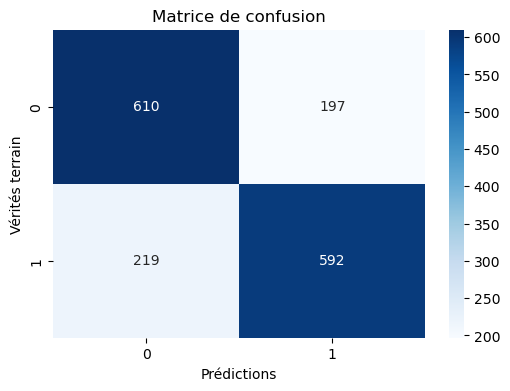

Rapport de classification :
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       807
           1       0.75      0.73      0.74       811

    accuracy                           0.74      1618
   macro avg       0.74      0.74      0.74      1618
weighted avg       0.74      0.74      0.74      1618



In [216]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Faire des prédictions sur le jeu de test
y_pred_probs = model_use.predict(X_test_embedded)  # Prédictions en probabilités
y_pred = (y_pred_probs > 0.5).astype("int32")   # Conversion en classes (0 ou 1)

# 2. Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# 3. Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.savefig('confusion_matrix.png')
plt.show()

# 4. Afficher le rapport de classification
class_report = classification_report(y_test, y_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


# Test Roberta tweets sentiment analysis pré-entrainé vs fine-tuning

## Modèle Roberta Tweets pré-entrainé

In [ ]:
# pip install transformers torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, classification_report

# Charger le tokenizer et le modèle depuis Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Vérifier si un GPU est disponible et définir l'appareil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Fonction pour prédire le sentiment avec le modèle pré-entrainé
def predict_sentiment_roberta(texts):
    # Tokeniser les textes en entrée
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

    # Passer le modèle en mode d'évaluation
    model.eval()

    # Passer en avant, obtenir les logits
    with torch.no_grad():
        outputs = model(**inputs)

    # Obtenir les classes prédites
    logits = outputs.logits
    predicted_classes = torch.argmax(logits, dim=1)

    return predicted_classes

# Mapper les prédictions du modèle RoBERTa à vos étiquettes cibles
def map_roberta_to_custom_labels(roberta_prediction):
    # RoBERTa a 3 classes : [négatif, neutre, positif]
    # Nous allons mapper neutre et négatif à 'négatif' (1), positif à 'positif' (0)
    return 1 if roberta_prediction in [0, 1] else 0

# Processus pour prédire les sentiments sur les données
def process_and_predict(df):
    predicted_labels = []

    for text in df['text']:
        # Prédire le sentiment pour chaque tweet
        roberta_prediction = predict_sentiment_roberta([text])[0].item()

        # Mapper le sentiment RoBERTa à vos labels customisés
        custom_label = map_roberta_to_custom_labels(roberta_prediction)
        predicted_labels.append(custom_label)

    return predicted_labels

# Augmentation des hyperparamètres : Augmenter le nombre d'époques
num_epochs = 5  # Essaye de jouer avec ce paramètre pour observer les résultats

# Tuning de l'hyperparamètre : Taille maximale des tokens
max_length = 256  # Ajuster selon tes besoins (par exemple, 128, 256, 512)

# Prédiction sur le jeu de données d'entraînement et de test
train_predictions = process_and_predict(train_df)
train_labels = train_df['target'].tolist()

test_predictions = process_and_predict(test_df)
test_labels = test_df['target'].tolist()

# Évaluer les résultats
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

# Rapport de classification pour plus d'informations
print("\nClassification Report on Train Data:")
print(classification_report(train_labels, train_predictions, target_names=["positive", "negative"]))

print("\nClassification Report on Test Data:")
print(classification_report(test_labels, test_predictions, target_names=["positive", "negative"]))


La tendance du modèle pré-entrainé est de bien mieux prédire la classe 0 (sentiment positif) et le résultat en terme d'exactitude de prédiction est équivalent à celui obtenu par simple régression logistique.

## Modèle Roberta Tweets fine-tuné

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load the tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
# Freeze all layers except the last classification layer
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:
import torch
from torch.utils.data import Dataset

# Custom Dataset class to handle tokenization
class TweetDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        target = self.targets[index]

        # Tokenization
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
# # Sous-échantillonage de train_df
# from sklearn.model_selection import train_test_split

# # Taille de l'échantillon (20% du total)
# sample_size = 0.2

# # Création du sous-échantillon avec stratification sur la colonne 'target'
# train_sample, _ = train_test_split(train_df,
#                                    test_size=1 - sample_size,
#                                    stratify=train_df['target'],
#                                    random_state=42)

# # Affichage de la répartition des classes dans le sous-échantillon
# print(train_sample['target'].value_counts(normalize=True))

In [ ]:
# Recap modèle et assignation de device pour le calcul
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
from tweet_dataset import TweetDataset  # Importer la classe depuis le module séparé

# Function to create the DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = TweetDataset(
        texts=df['text'].to_numpy(),
        targets=df['target'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4  # Adjust according to your machine
    )

In [ ]:
# Main execution block
if __name__ == "__main__":
    maxlen = 40  # Max tokens
    batch_size = 16  # Increase to lower calculation time

    # Prepare the data
    train_dataloader = create_data_loader(train_df, tokenizer, maxlen, batch_size)
    test_dataloader = create_data_loader(test_df, tokenizer, maxlen, batch_size)
    # Example usage of DataLoader (test de l'utilisation de la classe tweet_dataset
    # for batch in train_dataloader:
    #     print(batch)
    #     break  # Remove this line to process the full dataset

In [ ]:
from torch.optim import AdamW
# Optimizer and learning rate (adjustable)
optimizer = AdamW(model.parameters(), lr=0.0001)

In [ ]:
# Training function
def train_epoch(model, dataloader, optimizer, device):
    model = model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=targets
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        total_correct += torch.sum(preds == targets)
        total_samples += targets.size(0)

        loss.backward()
        optimizer.step()

    return total_correct.double() / total_samples, total_loss / total_samples

# Evaluation function
def eval_model(model, dataloader, device):
    model = model.eval()
    total_correct = 0
    total_samples = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == targets)
            total_samples += targets.size(0)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    accuracy = total_correct.double() / total_samples
    return accuracy, predictions, true_labels

In [ ]:
epochs = 20  # Adjust as necessary

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, device)
    print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

In [ ]:
# Evaluate the model on the test set
test_acc, test_preds, test_true = eval_model(model, test_dataloader, device)
print(f'Test Accuracy: {test_acc:.4f}')

# Classification report
print("\nClassification Report on Test Data:")
print(classification_report(test_true, test_preds, target_names=["positive", "negative"]))

In [ ]:
from datetime import datetime

# Get current date and time
now = datetime.now()
dt_string = now.strftime("%m_%d_%Y_%H_%M")

# Save the model
model_save_path = f'./models/roberta_fine_tuned_{dt_string}'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")

Le fine-tuning permet de gagner 10% d'exactitude, la classe positive a un meilleur recall que la classe négative ce qui est intéressant pour notre application métier.

# Test de déploiement local du meilleur modèle avancé

### Streamlit (retourne positif ou négatif)

In [83]:
# Ajustement de l'environnement aux dépendances du modèle
import mlflow

# Remplacez `model_uri` par le chemin de votre modèle
model_uri = 'runs:/9da4f92db62c447eb958dfd7f07133ce/bert_with_preprocessing'
env_file = mlflow.pyfunc.get_model_dependencies(model_uri)

# Installez les dépendances
import subprocess
subprocess.call(["pip", "install", "-r", env_file])


2024/11/13 16:50:01 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r C:\Users\cecil\AppData\Local\Temp\tmprzzf0db9\bert_with_preprocessing\requirements.txt'.


0

In [ ]:
%pip install -r C:\Users\cecil\AppData\Local\Temp\tmprzzf0db9\bert_with_preprocessing\requirements.txt

In [85]:
# Suppression des opérations personnalisées oneDNN
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [88]:
# Dans le terminal: streamlit run app.py
import subprocess

# Remplacez `app.py` par le nom de votre fichier Streamlit
process = subprocess.Popen(["streamlit", "run", "app.py"])

# Vous pouvez ajouter un lien vers l'application dans le notebook
from IPython.display import display, Markdown
display(Markdown("[Cliquez ici pour ouvrir l'application Streamlit](http://localhost:8501)"))


[Cliquez ici pour ouvrir l'application Streamlit](http://localhost:8501)

### Flask

In [185]:
# %run deploiement_local_flask.py
%run deploiement_local_flask_modeleAzure.py

 * Serving Flask app 'deploiement_local_flask_modeleAzure'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [21/Nov/2024 10:55:46] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Nov/2024 10:55:46] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [21/Nov/2024 10:55:59] "POST / HTTP/1.1" 200 -


Le modèle est fonctionnel avec le serving local en le chargeant depuis le registry local ou depuis le stockage Azure.<br>
Par contre la solution gratuite d'Azure Webapp ne permet pas de déployer ce modèle;